In [1]:
import numpy as np
#from scipy.integrate import solve_ivp
#from scipy.signal import spectrogram
import matplotlib.pyplot as plt
#from pyaxi_numerics import set_params, solve_system, get_text_params

verbosity = 9
use_tex_format = False

In [2]:
# LaTeX Formatting for Plots
if use_tex_format:
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
    })
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

    SMALL_SIZE = 8
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20

    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    '''
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the x tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the y tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', labelsize=BIGGER_SIZE, titlesize=BIGGER_SIZE)  # fontsize of the figure title
    '''

# Scratchwork

In [29]:
# TODO
sklearn_process = False
if sklearn_process:
    from sklearn.neural_network import MLPClassifier, MLPRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVC

    ## TODO: Data generation, importing, and preprocessing

    # TODO: load dataset
    from sklearn.datasets import make_classification
    X, y = make_classification(random_state = 0, n_features = 20, n_informative = 18, n_classes = 3)

    # TODO: split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [30]:
# TODO
if sklearn_process:
    # Create dataset processing and classification pipeline
    model_svc = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
    model_mlp = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(max_iter=400))])
    models = [model_svc, model_mlp]

    # Fit model to training dataset
    for model in models:
        print(list(model.named_steps.keys())[1])
        model.fit(X_train, y_train)
        # Evaluate fit with test dataset
        print("Score: %.2f" % model.score(X_test, y_test))
        print(" --------------------------------------- ")

In [31]:
## Optical Depth Calculations (WIP)
if True:
    import numpy as np
    c = 2.998e10   # [cm/s]
    h = 6.582e-16  # [eV s]
    G = 6.674e-13  # [N cm^2/g^2]
    
    # parameters of theory
    l1 = l2 = l3 = l4 = 1.  # unitless
    L3 = L4 = 1e11          # [eV]
    example_eps = 1.        # unitless
    example_Fpi = 1e21      # [eV]
    unitless_e  = 0.3       # unitless electron charge
    M_planck = np.sqrt(h*2*np.pi*c/G)
    
    ## Scattering Cross-Section
    k_example = 1            # [m]  =  3.85e+13 [Hz]
    m_example = 1            # [m]
    u_example = 1.414e-06    # [eV]
    coupling_example = 1
    cutoff_example   = 1e5   # [eV]
    k_cutoff_example = 200   # [m]
    
    cs_to_units = lambda cs: cs * (h ** 2) * (c**3)
    # crossterm FFdual
    cross_sec_1 = lambda k=k_example, m=m_example, l=coupling_example, L=cutoff_example, c=c, h=h, G=G: (((l ** 2) * m)/(6*np.pi*(L**4))) * ((k ** 4)/((m + 2*k)**3))
    # pi_0 FFdual (TODO)
    cross_sec_0 = lambda k=k_example, m=m_example, l=coupling_example, L=cutoff_example, c=c, h=h, G=G: 0
    
    print('Example cross-section values:')
    #print('   sigma_0 = %.3e [eV]^-2 = %.3e [cm]^2' % (cross_sec_0(), cs_to_units(cross_sec_0())))
    print('   sigma_1 = %.3e [eV]^-2 = %.3e [cm]^2' % (cross_sec_1(), cs_to_units(cross_sec_1())))
    
    ## Optical Depth
    density_example = 4e9   # [eV/cm^3]
    
    # Simple optical depth calculation (tau = sigma * n)
    tau_simple = lambda cs, rho=density_example, m_u=u_example, c=c: (rho/m_u) * cs_to_units(cs)
    # Weinberg calculation
    # TODO: check the definitions and units on these
    tau_weinberg = lambda cs, rho=density_example, m_u=u_example, k_u=u_example, k_peak=k_example, k_step=1, k_max=k_cutoff_example, c=c: (rho/m_u) / ((k_u*k_peak*c)*h) * np.sum([cs(k) for k in np.arange(1,k_cutoff_example,k_step)])
    
    print('\nExample optical depth values:')
    #print('   tau_0 (simple) = %.3e [cm]^-1' % tau_simple(cross_sec_0()))
    #print('   tau_0 (weinberg) = %.3e [cm]^-1' % tau_weinberg(cross_sec_0()))
    print('   tau_1 (simple) = %.3e [cm]^-1' % tau_simple(cross_sec_1()))
    print('   tau_1 (weinberg) = %.3e [???]' % tau_weinberg(cross_sec_1))

Example cross-section values:
   sigma_1 = 1.965e-23 [eV]^-2 = 2.294e-22 [cm]^2

Example optical depth values:
   tau_1 (simple) = 6.489e-07 [cm]^-1
   tau_1 (weinberg) = 1.318e+08 [???]


In [32]:
### Length Scales of different astrophysical scenarios
##       - TODO:  Astrophysical or formation motivated reasoning for selecting a given Mass or Radius to solve for, given density
##       - TODO:  Axion minicluster (planetary), Axion star, axion clump (~5 parsec), axion DM galaxy halo, galaxy supercluster-sized halo

## TODO: - Compare different length scales and energy density values against optical depth.
##       - Sanity check to ensure that optical depth is not too high

M_sun    = 1.988e33    # [g]
M_sun_eV = 1.115e66    # [eV/c^2]
g_to_eV  = 5.61e32     # [eV/c^2]
pc_to_cm = 3.086e18    # [cm]

## Axion Stars
R_star = 1.          # [cm], can be determined by mass
M_star = 1.          # [m_sun], can be determined by radius
# ALP properties
m_axion = (m_example * u_example)
g_axion = (coupling_example / cutoff_example)
# axion decay constant
f_axion = example_Fpi
# initial axion field amplitude
a_0 = 1.

## Axion star radius relations
# TODO: Find a better reference than (Iwazaki 2022), whose units don't make any sense
# note: per above, R_star ~ 1/k_axion
fixed_M = True
if fixed_M:
    R_star = 1./(G * m_axion**2 * (M_star*M_sun))
else:
    M_star = (np.pi * (1./2) * (m_axion/g_to_eV)**2 * (f_axion/(g_to_eV * c**2))**2 * a_0**2 * R_star**3) / M_sun

# Critical Coupling (Chung-Jukko 2023)
# (values of coupling constant above this will rapidly decay via parametric resonance)
g_crit = (1.66e-17)/(1e9) * ((M_star)*(m_axion/1e-11))**(-1.35)     # [eV]^-1
# (timescale of decay)
t_crit = (g_axion - g_crit)**(-0.87)     # [TODO: units???]

# Axion star energy density
rho_star = (M_star*M_sun*g_to_eV)/((4/3)*np.pi*R_star**3)    # [eV / cm^3]

# Axion star optical properties:
print('Axion Star:')
print('   M = %.1f [m_sun]   |   R = %.3e [cm]   |   rho = %.3e [eV/cm^3]  |   m_a = %.3e [eV]   |   g_crit = %0.1e [eV]^-1' % (M_star, R_star, rho_star, m_axion, g_crit))
print('Optical Depth: ')
#print('   tau_0 (simple) = %.3e [cm]^-1' % tau_simple(cross_sec_0(), rho=rho_star, m_u=m_axion))
#print('   tau_0 (weinberg) = %.3e [cm]^-1' % tau_weinberg(cross_sec_0(), rho=rho_star, m_u=m_axion))
print('   tau_1 (simple) = %.3e [cm]^-1' % tau_simple(cross_sec_1(), rho=rho_star, m_u=m_axion))
print('   tau(R) = %.3e' % (tau_simple(cross_sec_1(), rho=rho_star, m_u=m_axion)*R_star))
print('   tau_1 (weinberg) = %.3e [???]' % tau_weinberg(cross_sec_1, rho=rho_star, m_u=m_axion))
print('   tau(R) = %.3e' % (tau_weinberg(cross_sec_1, rho=rho_star, m_u=m_axion)*R_star))

## TODO: Axion Miniclusters

## TODO: Axion Halos

Axion Star:
   M = 1.0 [m_sun]   |   R = 3.770e-10 [cm]   |   rho = 4.970e+93 [eV/cm^3]  |   m_a = 1.414e-06 [eV]   |   g_crit = 1.8e-33 [eV]^-1
Optical Depth: 
   tau_1 (simple) = 8.063e+77 [cm]^-1
   tau(R) = 3.039e+68
   tau_1 (weinberg) = 1.638e+92 [???]
   tau(R) = 6.175e+82


# Misc. Tools

In [33]:
## Optionally solve for certain model-dependent parameters
if True:
    from pyaxi_utils import fit_Fpi
    
    eps_in = 1e-10
    l1_in  = 1
    m_axion = 1e-10     # desired QCD axion reference mass
    
    F_fit = fit_Fpi(m_axion, eps_in, l1_in, fit_QCD=True, verbosity=9)

Fitting pi-axiverse to QCD axion parameter space
QCD    |    m_a  = 1.0e-10 [eV]
       |    g_a  = 3.8e-20 [GeV^-1]
       |    z_ag = 5.2e-02
       |    C_ag = 1.9e+00
pi-axi |    eps  = 1.0e-10   ----->   F_pi = 5.2e-01 [GeV]   ----->   m_I = 1.9e-29 [eV]
       |    m_pi = 1.0e-10 [eV]
       |    g_pi = 3.8e-20 [GeV^-1]
       |    z_pi = 5.2e-02
       |    C_pi = -1.7e-17


In [2]:
## Scan log files for large batch runs and identify errored/missing ARGFILE lines
## (Optionally rename log files accordingly)

# TODO: Print total number of errored / missing / completed files
# TODO: Identify missing logs (bad SLURM output path?) by matching .json filenames to print statements in log files
# TODO: Write code to count up parameter comfigurations at the end, and ensure it matches ARGFILE.

import os
import re
import numpy as np

def scan_log_files(directory, output_folder, scratch_folder=None, argfile_in=None, rename_in_place=False, output_errored=True, output_unlogged=True, chunked_outputs=True, remove_redundant=True, reseed_argfile=False, max_line_num=22680, chunk_size=1000, verbosity=0):
    # Patterns to match the line number, UUID, and the 'Done!' message
    line_pattern = re.compile(r"LINE (\d+):\s*python")
    uuid_pattern = re.compile(r"piaxiverse_main1_SU3_([a-f0-9]{40})")  # phash in log file
    done_pattern = re.compile(r"Done!")
    seed_pattern = re.compile(r"rng_seed:\s*(.*)$")
    argf_pattern = re.compile(r"ARGFILE:\s*(.*)$")

    unsuccessful_lines = []
    successful_lines = set()
    all_lines = []
    found_uuids = set()
    logfile_list = os.listdir(directory)
    all_jobs_successful = True
    seeds = np.full((max_line_num,), None)
    argfiles = set()

    scratch_directory = scratch_folder if scratch_folder is not None else os.path.join(directory, 'scratch')

    is_argfile_match = lambda argf1, argf2: argf1.replace('_seeded', '') == argf2.replace('_seeded', '')
    is_valid_argf = lambda argf: True if argf is None else is_argfile_match(os.path.basename(argf), os.path.basename(argfile_in)) if argfile_in is not None else True

    # Scan directory with log files
    for filename in logfile_list:
        # Only process .txt files
        if filename.endswith('.txt') and 'log' in filename:
            filepath = os.path.join(directory, filename)

            try:
                with open(filepath, 'r') as file:
                    line_number = None
                    job_successful = False
                    uuid = None
                    seed = None
                    argfile = None

                    nlines = 0
                    for line in file:
                        # Reset state at the start of a new run, for multi-run log files
                        new_line_match = line_pattern.search(line)
                        if new_line_match:
                            if line_number is not None:
                                # Process the previous run
                                if is_valid_argf(argfile):
                                    all_lines.append(line_number)
                                    nlines += 1
                                    if job_successful and uuid:
                                        found_uuids.add(uuid)
                                    if not job_successful:
                                        unsuccessful_lines.append(line_number)
                                        all_jobs_successful = False
                                        if reseed_argfile:
                                            if seeds[line_number-1] is not None:
                                                seeds[line_number-1] = seed
                                    if job_successful:
                                        successful_lines.add(line_number)
                                        if reseed_argfile:
                                            seeds[line_number-1] = seed

                                # Reset variables for the next run
                                line_number = None
                                job_successful = False
                                uuid = None
                                seed = None

                        #print(line)

                        # Search for the line number pattern
                        if line_number is None:
                            if new_line_match:
                                line_number = int(new_line_match.group(1))
                                if verbosity >= 3:
                                    print(f'LINE: {line_number}')
                        
                        # Search for given argfile
                        if argfile is None:
                            argfile_match = argf_pattern.search(line)
                            if argfile_match:
                                argfile = argfile_match.group(1).strip('\n')
                                argfiles.add(argfile)
                                if verbosity >= 3:
                                    print(f'ARGFILE: {os.path.basename(argfile)}')
                        
                        # Search for RNG seed (to reproduce errored runs)
                        if seed is None:
                            seed_match = seed_pattern.search(line)
                            if seed_match:
                                seed = seed_match.group(1).strip('\n')
                                if verbosity >= 3:
                                    print(f'SEED: {seed}')

                        # Check for the "Done!" line indicating successful completion
                        if done_pattern.search(line):
                            job_successful = True
                            if verbosity >= 3:
                                print(f'DONE: {job_successful}')

                        # Search for the UUID pattern
                        if uuid is None:
                            uuid_match = uuid_pattern.search(line)
                            if uuid_match:
                                uuid = uuid_match.group(1).strip('\n')
                                if verbosity >= 3:
                                    print(f'UUID: {uuid}')

                    # Process the last run in the file
                    if line_number:
                        if is_valid_argf(argfile):
                            all_lines.append(line_number)
                            nlines += 1
                            if job_successful and uuid:
                                found_uuids.add(uuid)
                            if not job_successful:
                                unsuccessful_lines.append(line_number)
                                # Don't flag total batch run as errored in N > 1 runs, the final one likely got cut off due to time
                                if nlines <= 1:
                                    all_jobs_successful = False
                                if reseed_argfile:
                                    # Prefer the successful run's seed to the errored one (legacy support workaround)
                                    if seeds[line_number-1] is not None:
                                        seeds[line_number-1] = seed
                            if job_successful:
                                successful_lines.add(line_number)
                                if reseed_argfile:
                                    seeds[line_number-1] = seed
                            # Optionally rename file
                            if rename_in_place:
                                nline_str = '%d' % line_number if nlines <= 1 else '%d-%d' % (np.min(all_lines), np.max(all_lines))
                                # TODO: How should we name log files with partial success rates?
                                new_filename = f'log_{nline_str}.txt' if all_jobs_successful else f'log_{nline_str}_ERR.txt'
                                new_filepath = os.path.join(directory, new_filename)
                                os.rename(filepath, new_filepath)
                                if verbosity >= 5:
                                    print(f'Renamed {filename} to {new_filename}')

            except Exception as e:
                print(f'Error processing {filename}: {e}')
                raise(e)

    # Clean up redundant files (assuming they have been renamed in previous steps)
    # TODO: Adapt this to account for files with multiple runs in them
    if remove_redundant:
        redundant_log_files = []
        for filename in logfile_list:
            filename_base = filename.split('.txt')[0].replace('_ERR', '')
            if filename.split('.txt')[0].split('_')[-1] == 'ERR' and filename_base.join('.txt') in logfile_list:
                redundant_log_files.append(filename)
                # Move to recycling bin, presumably in a scratch storage space with a finite retention policy
                if False:
                    old_filepath = os.path.join(directory, filename)
                    new_filepath = os.path.join(scratch_directory, filename)
                    os.rename(old_filepath, new_filepath)

    if reseed_argfile:
        if argfile_in is None:
            argfiles_base = set([os.path.basename(argf).replace('_seeded','') for argf in argfiles])
            if len(argfiles_base) > 2:
                print(f'Error reseeding argfile, log files in {directory} contain references to multiple base argfiles:')
                for argfile in argfiles_base:
                    print(f'    {argfile}')
            else:
                if len(argfiles) <= 0:
                    print('IndexError, no valid argfiles found!')
                for argfile_i in list(argfiles):
                    print(argfile_i,':',os.path.exists(argfile_i))
                    if os.path.exists(argfile_i):
                        argfile_in = argfile_i.replace('_seeded','')
                        break

        argfile_out = argfile_in
        
        if argfile_out is not None:
            argfile_out = f'{argfile_out}_seeded'
            #argfile_out = os.path.join(os.path.dirname(argfile_out), argfile_out)

            with open(argfile_in, 'r') as infile, open(argfile_out, 'w', newline='\n') as outfile:
                for line_i, line in enumerate(infile):
                    line_seed = ('--seed %s' % seeds[line_i]) if seeds[line_i] is not None else ''
                    outline = line.strip('\n') + line_seed
                    outfile.write(outline + '\n')
            print('Preseeded argfile generated: ', argfile_out)

    # Print results to console
    if output_errored or output_unlogged:
        unsuccessful_lines = sorted([line for line in set(unsuccessful_lines) if not(line in successful_lines)])
        successful_lines = sorted(list(successful_lines))
        all_lines = set(all_lines)
        total_errored = 0
        total_missing = 0

        if output_errored:
            if verbosity >= 1:
                print("\nUnsuccessful job LINE numbers:")
            if chunked_outputs:
                for i in range(0, int(np.ceil(float(max_line_num)/chunk_size))):
                    chunk_offset = (i*chunk_size)
                    minbound = chunk_offset + 1
                    maxbound = chunk_offset + chunk_size
                    if verbosity >= 1:
                        print(f'\n[{minbound} - {min(maxbound, max_line_num)}]')

                    errored_in_chunk = [line for line in unsuccessful_lines if line >= minbound and line <= maxbound]
                    errored_count = len(errored_in_chunk)
                    total_errored += errored_count
                    errored_count_str = '[N = %3s]' % str(errored_count) if errored_count > 0 else ''
                    if verbosity >= 1:
                        if len(unsuccessful_lines) == chunk_size:
                            print('ERRORED: [ALL]')
                        else:
                            print('ERRORED: %s' % errored_count_str, format_for_slurm_job_array(errored_in_chunk, offset=chunk_offset))

                    missing_in_chunk = [j for j in range(minbound, min(maxbound, max_line_num)+1) if j not in all_lines]
                    missing_count = len(missing_in_chunk)
                    total_missing += missing_count
                    missing_count_str = '[N = %3s]' % str(missing_count) if missing_count > 0 else ''
                    if verbosity >= 1:
                        if len(missing_in_chunk) == chunk_size:
                            print('MISSING: [ALL]')
                        else:
                            print('MISSING: %s' % missing_count_str, format_for_slurm_job_array(missing_in_chunk, offset=chunk_offset))
                    
                    if verbosity >= 1:
                        print('TO RERUN:', format_for_slurm_job_array(errored_in_chunk + missing_in_chunk, offset=chunk_offset))
            else:
                print(format_for_slurm_job_array(unsuccessful_lines, offset=0))

        # Display all output files in results folder without associated logs
        if output_unlogged:
            data_file_uuids = [data_filename.replace('.json','').split('_')[-1] for data_filename in os.listdir(output_folder) if '.json' in data_filename]
            data_file_root = '_'.join(os.listdir(output_folder)[0].replace('.json','').split('_')[:-1])
            unlogged = sorted([uuid for uuid in data_file_uuids if not('.npy' in uuid or '.pkl' in uuid or '.pdf' in uuid) and uuid not in found_uuids])
            total_unlogged = len(unlogged)
            if total_unlogged > 0:
                #if total_unlogged == total_missing:
                #    print('UNLOGGED: [ALL]')
                #else:
                if verbosity >= 2:
                    print('----------------------------------------------------------')
                    print('UNLOGGED: [N = %d]' % total_unlogged)
                    if verbosity >= 3:
                        print('          %s' % ('\n          '.join(unlogged)))
        
        # Print total counts for each category
        if verbosity >= 0:
            print('----------------------------------------------------------')
            print('TOTAL COMPLETED: %d' % len(successful_lines))
            print('TOTAL ERRORED: %d' % len(unsuccessful_lines))
            print('(TOTAL ERRORED: %d)' % total_errored)
            print('TOTAL MISSING: %d' % (max_line_num - (len(successful_lines) + len(unsuccessful_lines))))
            print('(TOTAL MISSING: %d)' % total_missing)
            if output_unlogged:
                print('TOTAL UNLOGGED: %d' % total_unlogged)
            print('----------------------------------------------------------')
            grand_total_count = len(successful_lines)+len(unsuccessful_lines)+(max_line_num - (len(successful_lines) + len(unsuccessful_lines)))
            print('GRAND TOTAL: %d' % grand_total_count)
            if output_unlogged:
                print('LOGGED + UNLOGGED: %d' % (len(successful_lines) + len(unsuccessful_lines) + total_unlogged))
            
            grand_total_count_2 = len(successful_lines) + total_errored + total_missing
            print('(GRAND TOTAL: %d)' % grand_total_count_2)
            if output_unlogged:
                print('(GRAND TOTAL + UNLOGGED: %d)' % (grand_total_count_2 + total_unlogged))
                print('(LOGGED + UNLOGGED: %d)' % (len(successful_lines) + total_errored + total_unlogged))
            if remove_redundant:
                print('----------------------------------------------------------')
                print('TOTAL REDUNDANT: %d' % len(redundant_log_files))

def format_for_slurm_job_array(num_list, offset=0):
    # Do not attempt to format empty lists
    if len(num_list) < 1:
        #return num_list
        return ''
        #return "[None]"
    
    # Sort the list of numbers in ascending order
    num_list = np.array(sorted(num_list)) - offset
    
    result = []
    start = num_list[0]
    end = num_list[0]

    for i in range(1, len(num_list)):
        if num_list[i] == end + 1:
            # Continue the sequence
            end = num_list[i]
        else:
            # Sequence broken, append current range to the result
            if start == end:
                result.append(f'{start}')
            else:
                result.append(f'{start}-{end}')
            # Start a new sequence
            start = num_list[i]
            end = num_list[i]

    # Append the last range
    if start == end:
        result.append(f"{start}")
    else:
        result.append(f"{start}-{end}")

    # Join all the parts with commas
    return ",".join(result)

# Path to where log files are stored
log_dir = os.path.expanduser('~/projects/pyAxiverse/logs/piaxi_main1/')
# Path to where data files are stored
output_dir = os.path.expanduser('~/projects/pyAxiverse/data/piaxiverse_main1_SU3/')
# Path to scratch storage space (recycling bin for redundant log files)
scratch_dir = os.path.expanduser('~/scratch/pyAxiverse/logs/scratch/piaxi_main1/')
# Path to locally stored argfile (necessary if this path is different from the original path used when the script was first run)
argfile_dir = os.path.expanduser('~/projects/pyAxiverse/ARGFILES/piaxiverse_main1_SU3')

if True:
    # Set output_unsuccessful_lines to True if you want to print the unsuccessful job LINE numbers
    scan_log_files(log_dir, output_dir, scratch_dir, rename_in_place=False, output_errored=True, argfile_in=argfile_dir, reseed_argfile=True, remove_redundant=True, max_line_num=22680, verbosity=1) # 22680


Preseeded argfile generated:  /u/loane2/projects/pyAxiverse/ARGFILES/piaxiverse_main1_SU3_seeded

Unsuccessful job LINE numbers:

[1 - 1000]
ERRORED:  
MISSING: [N =   2] 284-285
TO RERUN: 284-285

[1001 - 2000]
ERRORED:  
MISSING:  
TO RERUN: 

[2001 - 3000]
ERRORED:  
MISSING:  
TO RERUN: 

[3001 - 4000]
ERRORED: [N = 466] 535-1000
MISSING: [N = 467] 33-499
TO RERUN: 33-499,535-1000

[4001 - 5000]
ERRORED:  
MISSING:  
TO RERUN: 

[5001 - 6000]
ERRORED: [N =   1] 143
MISSING: [N =   5] 144-148
TO RERUN: 143-148

[6001 - 7000]
ERRORED: [N =   7] 21,95,266,654,825,863,867
MISSING: [N =   7] 827-831,869-870
TO RERUN: 21,95,266,654,825,827-831,863,867,869-870

[7001 - 8000]
ERRORED: [N =   8] 142,176,318,320,387,527,910-911
MISSING:  
TO RERUN: 142,176,318,320,387,527,910-911

[8001 - 9000]
ERRORED: [N =   5] 51,157,614,752,755
MISSING:  
TO RERUN: 51,157,614,752,755

[9001 - 10000]
ERRORED: [N =   8] 140,184-185,207,699,836,910,979
MISSING:  
TO RERUN: 140,184-185,207,699,836,910,979

[

In [19]:
from astropy import units, constants

# Unitful constants 

G_SI = 6.674e-11 # [N m^2 / kg^2]
c_SI = 2.998e8   # [m / s]
h_SI = 1.055e-34 # [kg m^2 / s]
h_eV = 6.582e-16 # [eV s]

G_hep = 4.215e-56 # [1 / eV^2]
c_hep = 1
h_hep = 1

G_cgs = 6.674e-8  # [dyne cm^2 / g^2]
c_cgs = 2.998e10  # [cm / s]
h_cgs = 1.055e-27 # [erg  s]

G_natural = 1
c_natural = 1
h_natural = 1

G_geometric = 1
c_geometric = 1
h_geometric = 2.612e-76  # [km^2]

# Print values in different unit systems
example_Fpi = 1e10  # [GeV]
example_L4  = 1e10  # [GeV]
example_mpi = 1e-8  # [eV]
mpi_unit = units.def_unit('mpi', example_mpi * units.eV)

print('Inputs: ')
print('    F_pi = %.1e [Gev]' % example_Fpi)
print('    L4   = %.1e [Gev]' % example_L4)
print('    m_pi = %.1e [eV]'  % example_mpi)

print('SI')
print('    F_pi = %s' % str((example_Fpi*units.GeV).to('m^2 kg /s^2')))
print('    L4   = %s' % str((example_L4*units.GeV).to('m^2 kg /s^2')))
print('    m_pi = %s' % str((example_mpi*units.eV).to('kg', equivalencies=units.mass_energy())))

print('natural')
print('    F_pi = %s' % str((example_Fpi*units.GeV).to('m^2 kg /s^2', equivalencies=units.mass_energy())))
print('    L4   = %s' % str((example_L4*units.GeV).to('m^2 kg /s^2', equivalencies=units.mass_energy())))
print('    m_pi = %s' % str((example_mpi*units.eV).to('kg', equivalencies=units.mass_energy())))

print('mpi')
print('    F_pi = %s' % str((example_Fpi*units.GeV).to(mpi_unit)))
print('    L4   = %s' % str((example_L4*units.GeV).to(mpi_unit)))
print('    m_pi = %s' % str((example_mpi*units.eV).to(mpi_unit)))

Inputs: 
    F_pi = 1.0e+10 [Gev]
    L4   = 1.0e+10 [Gev]
    m_pi = 1.0e-08 [eV]
SI
    F_pi = 1.6021766339999999 kg m2 / s2
    L4   = 1.6021766339999999 kg m2 / s2
    m_pi = 1.7826619216278976e-44 kg
natural
    F_pi = 1.6021766339999999 kg m2 / s2
    L4   = 1.6021766339999999 kg m2 / s2
    m_pi = 1.7826619216278976e-44 kg
mpi
    F_pi = 1e+27 mpi
    L4   = 1e+27 mpi
    m_pi = 1.0 mpi


In [6]:
from astropy import units, constants

print(constants.G.to('N m^2 / kg^2'))
print(constants.c.to('m / s'))
print(constants.hbar.to('m^2 kg / s'))

print(constants.G.to('fm^5 s^-4 / eV', equivalencies=[units.mass_energy(), units.spectral()]))
print((constants.hbar*(constants.G / constants.c**3)).to('km^2', equivalencies=[units.mass_energy(), units.spectral()]))

6.6743e-11 m2 N / kg2
299792458.0 m / s
1.0545718176461565e-34 kg m2 / s
1.0693407508306193e+46 fm5 / (eV s4)
2.6122803039748722e-76 km2


# Analysis

In [2]:
## Plot Single Case
if False:
    from pyaxi_utils import plot_single_case, load_single_result
    
    #plot_single_case('3_neutrals_5f6d4c42050e31fa8d06ce7d9fc526e1eff881f3.json', output_dir='./test_data/', version='v2.8', tex_fmt=use_tex_format)
    plot_single_case('debug_bbbcfee89c436a9c11885e23159ef57a33e53985.json', output_dir='./scratch/', version='v3.2', tex_fmt=use_tex_format, add_colorbars=True, k_samples_in=[-1])

In [3]:
## TODO/WIP: Properly label and/or mask forbidden or experimentally excluded regions of parameter space
# TODO: Plot theoretically forbidden regions on AxionPhoton plots?
def enforce_constraints(series_in):
    """Enforce a series of optional constraints on parameter space selections."""

    # Label whether or not F_pi and QCD axion conform to desired relations
    series_in['fit_F_pi'] = check_Fpi_fit(series_in['eps'], series_in['m_u'], series_in['l1'], series_in['F'], sens=2., fit_QCD=False, verbosity=0)
    series_in['fit_QCD']  = check_Fpi_fit(series_in['eps'], series_in['m_u'], series_in['l1'], series_in['F'], sens=2., fit_QCD=True,  verbosity=0)

    # WIP: Enforce cosmologically stable lifetimes
    is_cosmo_stable = lambda m_in, F_pi=series_in['F'], eps=series_in['eps']: cosmo_stability(m_in, F_pi, eps) <= 1.2

    ## Freeze-in Relic Density for charged species
    H_infl = 1e19   # Hubble at Inflation [eV]
    T_re   = 1e18   # Temperature of reheating [eV]
    w_re   = 0      # Equation of state (at reheating)
    M_pl   = 1.2e27 # Planck Mass [eV]
    rd_a = lambda m_in, H=H_infl, M=M_pl: m_in/np.sqrt(H*M)
    rd_b = lambda T=T_re, H=H_infl, M=M_pl: np.sqrt(H*M)/T
    relic_density_charged = lambda m_in, F_pi, eps, w=w_re, H=H_infl, T=T_re, M=M_pl: \
        (5e-3) * (((10*np.pi**2)**(-w/(1+w)))/(2*(1+w))) * (eps**4) * (np.exp(10*(3-rd_a(m_in,H,M)*np.sqrt(rd_b(T,H,M))))/(rd_b(T,H,M)**(4/(1+w)-(1/2))))

    # WIP: Enforce minimal charged relic density
    omega_c = np.sum([relic_density_charged(mc_in, F_pi=series_in['F'], eps=series_in['eps']) for mc_in in series_in['m'][2]])
    is_crd_min = lambda m_in: relic_density_charged(m_in, F_pi=series_in['F'], eps=series_in['eps']) <= 0.01
    
    return series_in

## Distribution Analysis

In [3]:
## Dependency imports and declarations for data preprocessing, unit handling, and print formatting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
from pyaxi_utils import load_all, load_case, get_units_from_params, classify_resonance, n_p, n_k, cosmo_stability, fit_Fpi, \
                        check_Fpi_fit, calc_local_phase_diffs, calc_global_phase_diffs

#np.warnings.filterwarnings("error", category=np.VisibleDeprecationWarning)
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

from swifter import set_defaults
set_defaults(progress_bar=False)

# Set dtypes and print formats for each column
param_map = {
    "config_name":       [str,             None],
    "file_name":         [str,             None],
    "units":             ['object',        None],
    "A_0":               [np.float32,      None],
    "A_pm":              [np.int32,        None],
    "A_sens":            [np.float32,      None],
    "Adot_0":            [np.float32,      None],
    "F":                 [np.float64,      'sci'],
    "G":                 [np.float64,      'sci'],
    "L3":                [np.float64,      'sci'],
    "L4":                [np.float64,      'sci'],
    "N_c":               [np.int32,        None],
    "N_n":               [np.int32,        None],
    "N_r":               [np.int32,        None],
    "N_tot":             [np.int32,        None],
    "amps":              [np.ndarray,      'sci'],
    "c":                 [np.float32,      'sci'],
    "d":                 [np.ndarray,      'pi'],
    "Th":                [np.ndarray,      'pi'],
    "dqm":               [np.ndarray,      'sci'],
    "e":                 [np.float32,      None],
    "eps":               [np.float64,      'sci'],
    "eps_c":             [np.ndarray,      'int'],
    "g_pi":              [np.float64,      'sci'],
    "g_qed":             [np.float64,      'sci'],
    "g_3":               [np.float64,      'sci'],
    "g_4":               [np.float64,      'sci'],
    "h":                 [np.float64,      'sci'],
    "disable_P":         [bool,            None],
    "disable_B":         [bool,            None],
    "disable_C":         [bool,            None],
    "disable_D":         [bool,            None],
    "int_method":        [str,             None],
    "jupyter":           ['Int64',         None],
    "k_0":               [np.float32,      'sci'],
    "k_class_arr":       [np.ndarray,      None],
    "k_mean_arr":        [np.ndarray,      None],
    "k_num":             [np.int32,        'int'],
    "k_peak_arr":        [np.ndarray,      'sci'],
    "k_ratio_arr":       [np.ndarray,      'sci'],
    #"k_sens_arr":        [np.ndarray,      None],
    "k_span":            [np.ndarray,      'float'],
    "l1":                [np.int32,        None],
    "l2":                [np.int32,        None],
    "l3":                [np.int32,        None],
    "l4":                [np.int32,        None],
    "m":                 [np.ndarray,      'sci'],
    "m_0":               [np.float64,      'sci'],
    "m_c":               [np.ndarray,      'sci'],
    "m_n":               [np.ndarray,      'sci'],
    "m_q":               [np.float64,      'sci'],
    "m_r":               [np.ndarray,      'sci'],
    "m_u":               [np.float64,      'sci'],
    "mem_per_core":      ['Int64',         None],
    "mem_per_node":      ['Int64',         None],
    "mu_Th":             [np.float32,      'pi'],
    "mu_d":              [np.float32,      'pi'],
    "num_cores":         [np.int32,        None],
    "p":                 [np.ndarray,      'sci'],
    "p_0":               [np.float64,      'sci'],
    "p_c":               [np.ndarray,      'sci'],
    "p_n":               [np.ndarray,      'sci'],
    "p_r":               [np.ndarray,      'sci'],
    "p_t":               [np.float64,      'sci'],
    "parallel":          [bool,            None],
    "job_qos":           [str,             None],
    "job_partition":     [str,             None],
    "qc":                [np.ndarray,      'float'],
    "qm":                [np.ndarray,      'sci'],
    "res_band":          [np.ndarray,      'sci'],
    "res_band_class":    [str,             None],
    "res_class":         [str,             None],
    "res_con":           [np.float32,      None],
    "inf_con":           [np.float64,      None],
    "res_freq":          [str,             None],
    "res_freq_class":    ['object',        None],
    "res_freq_label":    [str,             None],
    "res_ratio_f":       [np.float64,      'sci'],
    "res_ratio_m":       [np.float64,      'sci'],
    "rescale_amps":      [bool,            None],
    "rescale_consts":    [bool,            None],
    "rescale_k":         [bool,            None],
    "rescale_m":         [bool,            None],
    "seed":              [str,             None],
    "sig_Th":            [np.float32,      'pi'],
    "sig_d":             [np.float32,      'pi'],
    "t_num":             [np.int32,        None],
    "t_res":             [np.float32,      'float'],
    "t_sens":            [np.float32,      'sci'],
    "t_span":            [np.ndarray,      'float'],
    "t_u":               [np.float64,      'sci'],
    "T_r":               [np.float32,      'float'],
    "T_n":               [np.float32,      'float'],
    "T_c":               [np.float32,      'float'],
    "T_u":               [np.float32,      'float'],
    "use_natural_units": [bool,            None],
    "use_mass_units":    [bool,            None],
    "dimensionful_p":    [bool,            None],
    "time_elapsed":      [str,             None],
    "unitful_amps":      [bool,            None],
    "unitful_k":         [bool,            None],
    "unitful_m":         [bool,            None],
    "xi":                [np.ndarray,      'float'],
}

dtype_map = {key: val[0] for key,val in param_map.items()}
print_fmt = {key: val[1] for key,val in param_map.items()}

#df[["A"]].describe().applymap(lambda x: f"{x:0.3f}")
def df_fmt(x, fmt=None):
    if pd.isna(x):
        return ''
    if type(x) in [float, np.float32, np.float64] or fmt in ['sci', 'pi', 'float']:
        if fmt == 'sci':
            return f'{x:.1e}'
        elif fmt == 'pi':
            xp = x/np.pi
            return f'{xp:0.1f}'
        else:
            return f'{x:0.1f}'
    elif type(x) in [int, np.int32, np.int64, 'Int64'] or fmt in ['int']:
        if x == 'None':
            return None
        else:
            return f'{x:d}'
    elif type(x) is str:
        if x.lower() == 'nan':
            return ''
        else:
            return x
    else:
        #print(x, type(x))
        return x

# WIP: Pretty printing dataframes
def df_pprint(df_in):
    df = df_in.copy()
    for param in df:
        df[param].apply(df_fmt, args=(print_fmt[param],))
    return df

def df_describe(df_in, use_pprint=False, include='all'):
    if use_pprint:
        return df_pprint(df_in.describe(include=include))
    else:
        return df_in.describe(include=include)

In [4]:
## Helper functions for data preprocessing
def prepare_data(config_name, output_root='~/scratch', version='v3.2.7', reclassify=None, recalc_phase_diffs=False, recalc_couplings=True, load_images=False, multithreaded=True, combined_folder=False):
    """Load and prepare data for future functions"""

    if config_name == 'all':
        params, results, _, coeffs = load_all(output_root, version, load_images=load_images)
    else:
        params, results, _, coeffs = load_case(config_name, output_root, version, load_images=load_images, combined_folder=combined_folder)

    # Convert to DataFrame
    params_df  = pd.DataFrame(params)

    # Free up memory
    del params

    # Extract unit mappings
    units_in = params_df.pop('units')
    units_df = pd.DataFrame(units_in.tolist(), index=params_df.index)
    
    # TODO: Temp fix, remove this when no longer needed
    #if int(version.replace('v','').split('.')[0]) <= 2:
    #    params_df['jupyter'].fillna(False, inplace=True)
    # TODO: Temp fix, remove this when no longer needed
    #if int(version.replace('v','').split('.')[0]) <= 3:
    #    if 'N_tot' not in params_df.keys():
    #        params_df['N_tot'] = params_df['N_r'].astype(np.int32)+params_df['N_n'].astype(np.int32)+params_df['N_c'].astype(np.int32)

    # Preprocess stored parameter values and populate dataframe
    for col, dtype in dtype_map.items():
        #print('col: %s   |  dtype: %s' % (col,dtype))
        if col in params_df:
            try:
                if dtype is np.ndarray:
                    try:
                        if multithreaded:
                            params_df[col] = params_df[col].swifter.apply(np.array, dtype=object)
                        else:
                            params_df[col] = params_df[col].apply(np.array, dtype=object)
                    except (np.VisibleDeprecationWarning):
                        print('Deprecation: %s' % col)
                        print(params_df[col])
                        if multithreaded:
                            params_df[col] = params_df[col].swifter.apply(np.array)
                        else:
                            params_df[col] = params_df[col].apply(np.array)
                else:
                    params_df[col] = params_df[col].astype(dtype)
            except (OverflowError):
                print('Overflow: (%s) - %s' % (col, dtype))
        else:
            print('Missing parameter: %s' % col)
    n_cols = [ncol for ncol in params_df if ncol not in dtype_map.keys()]
    if len(n_cols) > 0:
        print('Unspecified parameters: %s' % n_cols)
    
    # Dataframe containing results of numerics and data for plotting
    res_arr = np.array(results[0], dtype=np.float64)[:,0,:]
    results_df = pd.DataFrame(res_arr)
    print(results_df.values.shape)

    # Optionally rerun resonance classification
    if reclassify is not None:
        sols_arr  = np.array(results[0], dtype=np.float64)
        recalc_resonance = lambda x: reclassify_resonance(x, results_in=sols_arr)
        if multithreaded:
            params_df = params_df.swifter.apply(recalc_resonance, axis=1)
        else:
            params_df = params_df.apply(recalc_resonance, axis=1)

    # Free up memory
    del results
    
    if recalc_phase_diffs:
        #df_from_series = lambda s, cols_in: pd.DataFrame.from_dict(dict(zip(s.index, s.values)), dtype=np.float32)
        d_cols  = ['mean_d_r', 'var_d_r', 'min_d_r', 'max_d_r', 'mean_d_n', 'var_d_n', 'min_d_n', 'max_d_n', 'mean_d_c', 'var_d_c', 'min_d_c', 'max_d_c', 'mean_d_tot', 'var_d_tot', 'min_d_tot', 'max_d_tot']
        Th_cols = ['mean_Th_r', 'var_Th_r', 'min_Th_r', 'max_Th_r', 'mean_Th_n', 'var_Th_n', 'min_Th_n', 'max_Th_n', 'mean_Th_c', 'var_Th_c', 'min_Th_c', 'max_Th_c', 'mean_Th_tot', 'var_Th_tot', 'min_Th_tot', 'max_Th_tot']

        get_local_diffs = lambda x: [d_item for d_cat in calc_local_phase_diffs(x['d']) for d_item in d_cat]
        if multithreaded:
            local_diffs  = params_df.swifter.apply(get_local_diffs, axis=1)
        else:
            local_diffs  = params_df.apply(get_local_diffs, axis=1)
        for idx, d_col in enumerate(d_cols):
            params_df[d_col] = local_diffs.apply(lambda x: x[idx])

        get_global_diffs = lambda x: [Th_item for Th_cat in calc_global_phase_diffs(x['Th']) for Th_item in Th_cat]
        if multithreaded:
            global_diffs = params_df.swifter.apply(get_global_diffs, axis=1)
        else:
            global_diffs = params_df.apply(get_global_diffs, axis=1)
        for idx, Th_col in enumerate(Th_cols):
            params_df[Th_col] = global_diffs.apply(lambda x: x[idx])

        '''
        params_df['mean_d_r'] = local_diffs.apply(lambda x: pd.DataFrame(x[0][0], dtype=np.float32))
        params_df['var_d_r']  = local_diffs.apply(lambda x: pd.DataFrame(x[0][1], dtype=np.float32))
        params_df['min_d_r']  = local_diffs.apply(lambda x: pd.DataFrame(x[0][2], dtype=np.float32))
        params_df['max_d_r']  = local_diffs.apply(lambda x: pd.DataFrame(x[0][3], dtype=np.float32))
        print('--------------------------')
        print(params_df['mean_d_r'].describe())
        print('--------------------------')
        print(params_df['var_d_r'].describe())
        print('--------------------------')
        print(params_df['min_d_r'].describe())
        print('--------------------------')
        print(params_df['max_d_r'].describe())
        print('--------------------------')
    
        params_df['mean_d_n'] = pd.DataFrame(local_diffs.apply(lambda x: pd.DataFrame(x, dtype=np.float32)[1][0]), dtype=np.float32)
        params_df['var_d_n']  = pd.DataFrame(local_diffs.apply(lambda x: pd.DataFrame(x, dtype=np.float32)[1][1]), dtype=np.float32)
        params_df['min_d_n']  = pd.DataFrame(local_diffs.apply(lambda x: pd.DataFrame(x, dtype=np.float32)[1][2]), dtype=np.float32)
        params_df['max_d_n']  = pd.DataFrame(local_diffs.apply(lambda x: pd.DataFrame(x, dtype=np.float32)[1][3]), dtype=np.float32)
    
        params_df['mean_d_c'] = pd.DataFrame(local_diffs.apply(lambda x: pd.DataFrame(x, dtype=np.float32)[2][0]), dtype=np.float32)
        params_df['var_d_c']  = pd.DataFrame(local_diffs.apply(lambda x: pd.DataFrame(x, dtype=np.float32)[2][1]), dtype=np.float32)
        params_df['min_d_c']  = pd.DataFrame(local_diffs.apply(lambda x: pd.DataFrame(x, dtype=np.float32)[2][2]), dtype=np.float32)
        params_df['max_d_c']  = pd.DataFrame(local_diffs.apply(lambda x: pd.DataFrame(x, dtype=np.float32)[2][3]), dtype=np.float32)
        
        params_df['mean_d_tot'] = pd.DataFrame(local_diffs.apply(lambda x: pd.DataFrame(x, dtype=np.float32)[3][0]), dtype=np.float32)
        params_df['var_d_tot']  = pd.DataFrame(local_diffs.apply(lambda x: pd.DataFrame(x, dtype=np.float32)[3][1]), dtype=np.float32)
        params_df['min_d_tot']  = pd.DataFrame(local_diffs.apply(lambda x: pd.DataFrame(x, dtype=np.float32)[3][2]), dtype=np.float32)
        params_df['max_d_tot']  = pd.DataFrame(local_diffs.apply(lambda x: pd.DataFrame(x, dtype=np.float32)[3][3]), dtype=np.float32)

        
        params_df['mean_Th_r'] = global_diffs.apply(lambda x: x[0][0])
        params_df['var_Th_r']  = global_diffs.apply(lambda x: x[0][1])
        params_df['min_Th_r']  = global_diffs.apply(lambda x: x[0][2])
        params_df['max_Th_r']  = global_diffs.apply(lambda x: x[0][3])
        
        params_df['mean_Th_n'] = global_diffs.apply(lambda x: x[1][0])
        params_df['var_Th_n']  = global_diffs.apply(lambda x: x[1][1])
        params_df['min_Th_n']  = global_diffs.apply(lambda x: x[1][2])
        params_df['max_Th_n']  = global_diffs.apply(lambda x: x[1][3])
        
        params_df['mean_Th_c'] = global_diffs.apply(lambda x: x[2][0])
        params_df['var_Th_c']  = global_diffs.apply(lambda x: x[2][1])
        params_df['min_Th_c']  = global_diffs.apply(lambda x: x[2][2])
        params_df['max_Th_c']  = global_diffs.apply(lambda x: x[2][3])
                                                  
        params_df['mean_Th_tot'] = global_diffs.apply(lambda x: x[3][0])
        params_df['var_Th_tot']  = global_diffs.apply(lambda x: x[3][1])
        params_df['min_Th_tot']  = global_diffs.apply(lambda x: x[3][2])
        params_df['max_Th_tot']  = global_diffs.apply(lambda x: x[3][3])
        '''

    if recalc_couplings:
        from pyaxi_utils import g_anomaly, g_coupling, alpha_off, alpha_sm
        # Coupling constants for triangle diagram, scalar QED, charged scattering, and neutral scattering interactions respectively
        get_g_pi  = lambda x: g_anomaly(x['F']/1e9,   l1=x['l1'], eps=x['eps'], fs_in=alpha_sm)  if x['N_r'] > 0 else None
        get_g_qed = lambda x: g_coupling(1,           li=x['l2'], eps=x['eps'], fs_in=alpha_off) if x['N_c'] > 0 else None
        get_g_3   = lambda x: g_coupling(x['L3']/1e9, li=x['l3'], eps=x['eps'], fs_in=alpha_sm)  if x['N_c'] > 0 else None
        get_g_4   = lambda x: g_coupling(x['L4']/1e9, li=x['l4'], eps=x['eps'], fs_in=alpha_sm)  if x['N_r'] + x['N_n'] > 0 else None
        if multithreaded:
            params_df['g_pi']  = params_df.swifter.apply(get_g_pi, axis=1)
            params_df['g_qed'] = params_df.swifter.apply(get_g_qed, axis=1)
            params_df['g_3']   = params_df.swifter.apply(get_g_3, axis=1)
            params_df['g_4']   = params_df.swifter.apply(get_g_4, axis=1)
        else:
            params_df['g_pi']  = params_df.apply(get_g_pi, axis=1)
            params_df['g_qed'] = params_df.apply(get_g_qed, axis=1)
            params_df['g_3']   = params_df.apply(get_g_3, axis=1)
            params_df['g_4']   = params_df.apply(get_g_4, axis=1)
    
    # TODO: Remove these fixes when no longer needed
    if 'N_tot' not in params_df.columns:
        get_N_tot = lambda x: x['N_r'] + x['N_n'] + x['N_c']
        if multithreaded:
            params_df['N_tot'] = params_df.swifter.apply(get_N_tot, axis=1)
        else:
            params_df['N_tot'] = params_df.apply(get_N_tot, axis=1)

    if 'job_qos' not in params_df.columns:
        if multithreaded:
            params_df['job_qos'] = params_df.swifter.apply(lambda x: None, axis=1)
        else:
            params_df['job_qos'] = params_df.apply(lambda x: None, axis=1)

    if 'job_partition' not in params_df.columns:
        if multithreaded:
            params_df['job_partition'] = params_df.swifter.apply(lambda x: None, axis=1)
        else:
            params_df['job_partition'] = params_df.apply(lambda x: None, axis=1)

    if 'mem_per_node' not in params_df.columns:
        if multithreaded:
            params_df['mem_per_node'] = params_df.swifter.apply(lambda x: -1, axis=1)
        else:
            params_df['mem_per_node'] = params_df.apply(lambda x: -1, axis=1)

    # Dataframe containing the functions corresponding to oscillating coefficients B(t), C+/-(t), D(t), and P(t)
    coeffs_df  = pd.DataFrame(coeffs)

    # Free up memory
    del coeffs
    
    return params_df, results_df, coeffs_df, units_df

def reclassify_resonance(series_in, results_in):
    """Reclassify tot_class, nk_class, and ratios for a given Series."""
    n_p_local = n_p
    n_k_local = n_k
    k_span = series_in['k_span']
    t_span = series_in['t_span']
    
    k_values = np.linspace(k_span[0], k_span[1], int(series_in['k_num']))
    times    = np.linspace(t_span[0], t_span[1], int(series_in['t_num']))
    nk_arr = np.array([n_p_local(k_i, series_in, results_in, k_values, times, n=n_k_local) for k_i,_ in enumerate(k_values)])
    
    nk_class, tot_class, nk_ratios, ratio_f, ratio_m, t_res, t_max = classify_resonance(series_in, nk_arr, k_span, method=reclassify)
    series_in['k_class_arr'] = nk_class
    series_in['k_ratio_arr'] = nk_ratios
    series_in['res_class']   = tot_class
    series_in['res_ratio_f'] = ratio_f
    series_in['res_ratio_m'] = ratio_m
    series_in['t_res']       = t_res
    
    return series_in

def plot_heatmaps(df):
    """Plot heatmaps of k_class_arr, k_ratio_arr, and k_peak_arr over multiple runs."""

    get_k_ratio = lambda arr, i: np.asarray(list(filter(None, map(lambda x: list(filter(None, x.strip().split(' ')))[i], arr.strip().replace(']','').strip().split('[')[1:]))), dtype=np.float64)
    #k_ratio_ser = lambda arr: pd.Series({'ratio': , 'ratio_max': , 't_res': , 't_max': })
    
    ## Assuming the arrays are already in the correct format
    # TODO: handle inf values in k_ratio_arr
    k_class_arr = df['k_class_arr']
    #k_ratio_arr = df['k_ratio_arr'].apply(lambda x: x[:,0])
    k_ratio_arr = df['k_ratio_arr'].apply(lambda x: get_k_ratio(x, 0))
    k_peak_arr  = df['k_ratio_arr'].apply(lambda x: get_k_ratio(x, 1))
    #t_res_arr   = df['k_ratio_arr'].apply(lambda x: get_k_ratio(x, 2))
    #t_max_arr   = df['k_ratio_arr'].apply(lambda x: get_k_ratio(x, 3))
    k_spans     = df['k_span']

    # Determine the global k-range
    global_k_min = min([span[0] for span in k_spans])
    global_k_max = max([span[1] for span in k_spans])
    total_k_modes = max([len(arr) for arr in k_class_arr])  # maximum number of k-modes
    
    # Convert string values to unique integers for plotting
    #unique_values = np.unique(np.concatenate(k_class_arr))
    unique_values = ['damp', 'none', 'burst', 'resonance']
    # TEMP/TODO: Remove 'aliases' logic when no longer needed
    class_aliases = {'semi':'burst', 'soft':'burst', 'injection':'burst', 'res':'resonance'}
    num_runs   = len(k_class_arr)
    num_values = len(k_class_arr[0])
    value_to_int = {value: idx for idx, value in enumerate(unique_values)}
    
    #k_class_arr = [[value_to_int[val] for val in row] for row in k_class_arr]
    #k_sens_arr  = [[val for val in row] for row in k_sens_arr]
    #k_peak_arr  = [[val for val in row] for row in k_peak_arr]
    
    if True:
        # Initialize combined heatmaps
        combined_k_class = np.full((len(k_class_arr), total_k_modes), np.nan)
        combined_k_ratio = np.full((len(k_ratio_arr), total_k_modes), np.nan)
        combined_k_peak  = np.full((len(k_peak_arr),  total_k_modes), np.nan)
        
        k_ratio_min = k_ratio_max = k_peak_min = k_peak_max = None

        # Fill in the combined heatmaps
        for idx, (k_class, k_ratio, k_peak, k_span) in enumerate(zip(k_class_arr, k_ratio_arr, k_peak_arr, k_spans)):
            start_idx = int((k_span[0] - global_k_min) * total_k_modes / (global_k_max - global_k_min))
            end_idx = start_idx + len(k_class)
            #print(k_class)
            combined_k_class[idx, start_idx:end_idx] = [value_to_int[val] if val in value_to_int.keys() else value_to_int[class_aliases[val]] for val in k_class]
            combined_k_ratio[idx, start_idx:end_idx] = k_ratio
            combined_k_peak[idx, start_idx:end_idx]  = k_peak
            
            k_ratio_min = min(k_ratio) if k_ratio_min is None else min(k_ratio_min, min(k_ratio))
            k_ratio_max = max(k_ratio) if k_ratio_max is None else max(k_ratio_max, max(k_ratio))
            k_peak_min  = min(k_peak)  if k_peak_min  is None else min(k_peak_min, min(k_peak))
            k_peak_max  = max(k_peak)  if k_peak_max  is None else max(k_peak_max, max(k_peak))

        # Plot the combined heatmaps
        plt.figure(figsize=(10, 12))
        ax1 = plt.subplot(3, 1, 1)
        im1 = plt.imshow(combined_k_class, aspect='auto', cmap='viridis')
        plt.title('k_class_arr')
        plt.ylabel('N')
        plt.xlabel('normalized k')

        ax2 = plt.subplot(3, 1, 2)
        im2 = plt.imshow(combined_k_ratio, aspect='auto', cmap='autumn')
        plt.title('k_ratio_arr')
        plt.ylabel('N')
        plt.xlabel('normalized k')

        ax3 = plt.subplot(3, 1, 3)
        im3 = plt.imshow(combined_k_peak, aspect='auto', cmap='autumn')
        plt.title('k_peak_arr')
        plt.ylabel('N')
        plt.xlabel('normalized k')
        
        # Add colorbars to indicate the mapping from integers back to string values
        cbar1 = plt.colorbar(im1, ax=ax1, ticks=list(value_to_int.values()))
        cbar1.set_ticklabels(list(value_to_int.keys()))

        cbar2 = plt.colorbar(im2, ax=ax2, ticks=np.linspace(k_ratio_min, k_ratio_max, 3))
        #cbar2.set_ticklabels(list(value_to_int.keys()))

        cbar3 = plt.colorbar(im3, ax=ax3, ticks=np.linspace(k_peak_min, k_peak_max, 3))
        #cbar3.set_ticklabels(list(value_to_int.keys()))
        

        plt.tight_layout()
        plt.show()
        
    else:
        fig, axs = plt.subplots(3, 1, figsize=(10, 15))

        im1 = axs[0].imshow(k_class_arr, aspect='auto', cmap='viridis')
        axs[0].set_title('k_class_arr heatmap')
        axs[0].set_xlabel('Index')
        axs[0].set_ylabel('Run')

        im2 = axs[1].imshow(k_ratio_arr, aspect='auto', cmap='autumn')
        axs[1].set_title('k_ratio_arr heatmap')
        axs[1].set_xlabel('Index')
        axs[1].set_ylabel('Run')

        im3 = axs[2].imshow(k_peak_arr, aspect='auto', cmap='autumn')
        axs[2].set_title('k_peak_arr heatmap')
        axs[2].set_xlabel('Index')
        axs[2].set_ylabel('Run')

        # Add colorbars to indicate the mapping from integers back to string values
        cbar1 = plt.colorbar(im1, ax=axs[0], ticks=list(value_to_int.values()))
        cbar1.set_ticklabels(list(value_to_int.keys()))

        cbar2 = plt.colorbar(im2, ax=axs[1], ticks=list(value_to_int.values()))
        cbar2.set_ticklabels(list(value_to_int.keys()))

        cbar3 = plt.colorbar(im3, ax=axs[2], ticks=list(value_to_int.values()))
        cbar3.set_ticklabels(list(value_to_int.keys()))

        plt.tight_layout()
        plt.show()

def plot_scatter(df):
    """Plot m_r vs F and p_t vs Lambda4 scatter plots over multiple runs, labeled by res_class."""
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    
    unique_classes = df['res_class'].unique()
    
    for res_cls in unique_classes:
        subset = df[df['res_class'] == res_cls]
        
        axs[0].scatter(subset['F'], subset['m_r'].str[0], label=f'Res Class {res_cls}')
        axs[1].scatter(subset['L4'], subset['p_t'], label=f'Res Class {res_cls}')
    
    axs[0].set_title('m_r vs F')
    axs[0].set_xlabel('F')
    axs[0].set_ylabel('m_r')
    
    axs[1].set_title('p_t vs Lambda4')
    axs[1].set_xlabel('Lambda4 (L4)')
    axs[1].set_ylabel('p_t')
    
    axs[0].legend()
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [5]:
## Load and prepare data for a specified category of runs
version   = ''
#version   = 'v3.2.8'
conf_name = 'piaxiverse_main1_SU3_sample_100'  # name of config identifier/subfolder from which to import data. Use 'all' for all (non-debug) datasets of a given version number.
#conf_name='all'

reclass_method = None
#reclass_method = 'heaviside'

params_data, results_data, coeffs_data, units_df = prepare_data(output_root='./data', config_name=conf_name, version=version, reclassify=reclass_method, recalc_phase_diffs=True, recalc_couplings=True, load_images=True, combined_folder=True)
print(params_data.columns)

if False:
    for param_row in params_data[:5]['Th']:
        print(param_row)
        print([Th_item for Th_cat in calc_global_phase_diffs(param_row, verbosity=9) for Th_item in Th_cat])

Missing parameter: units
Missing parameter: N_tot
Missing parameter: g_pi
Missing parameter: g_qed
Missing parameter: g_3
Missing parameter: g_4
Missing parameter: mem_per_node
Missing parameter: job_qos
Missing parameter: job_partition
Unspecified parameters: ['k_sens_arr']
(991, 1000)
Index(['A_0', 'A_pm', 'A_sens', 'Adot_0', 'F', 'G', 'L3', 'L4', 'N_c', 'N_n',
       ...
       'min_Th_tot', 'max_Th_tot', 'g_pi', 'g_qed', 'g_3', 'g_4', 'N_tot',
       'job_qos', 'job_partition', 'mem_per_node'],
      dtype='object', length=134)


In [6]:
## Postprocess Units
# TODO: Group runs by unit choices if more than one permutation exists? Maybe p-hashing the dict?
unique_units = {col: len(units_df[col].unique()) <= 1 for col in units_df.columns}
all_unique   = np.all([unique_units[key] for key in unique_units.keys()])
# Assume all runs included use the same units for now
if all_unique:
    unique_units = {col: units_df[col].unique()[0] for col in units_df.columns}
else:
    unique_units = {col: units_df[col].unique()[0] for col in units_df.columns if unique_units[col]}
    print('Non-unique units: ', [col for col in unique_units.keys() if not unique_units[col]])

# WIP: Organize mapping of units for each variable
# TODO: Double check this and make sure units are being handled properly throughout
#       the simulation
# TODO: Double check the below overrides (taken from print_param_space() in pyaxi_utils)
#       make sense and are okay to do, I forget why the code does this exactly...
units_map = {}
for u_key in ['m','m_c','m_n','m_r']:
    units_map[u_key] = unique_units['m']
for u_key in ['g_pi', 'g_qed', 'g_3', 'g_4']:
    units_map[u_key] = 'GeV'
for u_key in ['F']:
    units_map[u_key] = unique_units['F']
    if unique_units['F'] == 'm_u':
        units_map[u_key] = 'eV' # TODO: Check this! (F_pi value is always saved in eV)
    else:
        units_map[u_key] = unique_units['F']
for u_key in ['L3', 'L4']:
    if unique_units['Lambda'] == 'm_u':
        units_map[u_key] = 'eV' # TODO: Check this! (Lambda values are always saved in eV)
    else:
        units_map[u_key] = unique_units['Lambda']
for u_key in ['l1', 'l2', 'l3', 'l4']:
    units_map[u_key] = unique_units['lambda']
for u_key in ['amps']:
    units_map[u_key] = unique_units['amp']
for u_key in ['t_span','t_sens','t_res']:
    units_map[u_key] = unique_units['t']
for u_key in ['k_span']:
    if unique_units['k'] == 'eV':
        units_map[u_key] = 'm_u' # TODO: Check this! (k values are always saved in m_u)
    else:
        units_map[u_key] = unique_units['k']
for u_key in ['p','p_t','p_c','p_n','p_r']:
    units_map[u_key] = unique_units['p']
for u_key in ['Th','mu_Th','sig_Th']:
    units_map[u_key] = unique_units['Theta']
for u_key in ['d','mu_d','sig_d']:
    units_map[u_key] = unique_units['delta']
for u_key in ['c','h','G']:
    units_map[u_key] = unique_units[u_key]
for u_key in ['m_q', 'm_u']:
    units_map[u_key] = 'eV'
#param_units = {key: unique_units[units_map[key]] for key in units_map.keys()}
param_units = units_map

units_fmt = lambda key, prefix='', units=param_units: '' if key not in units.keys() else ('[%s%s]' % (prefix, units[key])) if units[key] != 1 else ''

In [7]:
## WIP: Visualize imported data for a category of runs
plot_heatmaps(params_data)
plot_scatter(params_data)

/u/loane2/.conda/envs/pyaxiverse/lib/python3.9/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

<Figure size 1000x1200 with 6 Axes>

In [8]:
## Analyze a run's plots TODO/WIP
if False:

    # Sample data (replace with actual data)
    #params, results, _, coeffs = load_single_result(filename='3_neutrals_5f6d4c42050e31fa8d06ce7d9fc526e1eff881f3', output_dir='./test_data/v2.8/3_neutrals/')
    

    # Placeholder for raw solution (replace with actual data when available)
    data = params_data
    raw_solution = results_data
    print(results_data)

    # Heatmap for raw solution
    plt.figure(figsize=(12, 8))
    sns.heatmap(raw_solution, cmap='viridis')
    plt.title("Heatmap of Raw Solution (Amplitude of Photon Field)")
    plt.xlabel("k-mode")
    plt.ylabel("Time")
    plt.show()

    # Bar plots for k_mean_arr, k_peak_arr, and k_sens_arr
    k_modes = np.arange(1, len(data["k_mean_arr"]) + 1)
    plt.figure(figsize=(12, 8))
    plt.bar(k_modes, data["k_mean_arr"], label="k_mean_arr", alpha=0.6)
    plt.bar(k_modes, data["k_peak_arr"], label="k_peak_arr", alpha=0.6)
    plt.bar(k_modes, data["k_sens_arr"], label="k_sens_arr", alpha=0.6)
    plt.xlabel("k-mode")
    plt.ylabel("Value")
    plt.title("Bar Plots for k_mean_arr, k_peak_arr, and k_sens_arr")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Categorical plot for k_class_arr
    plt.figure(figsize=(12, 8))
    sns.countplot(data["k_class_arr"])
    plt.title("Distribution of Classification Labels")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()


In [8]:
## TODO: k-mode instability (floquet) plots
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_k_vs_parameter_heatmap(df, parameter, mode='absolute'):
    # Extract global k range
    global_k_min = df['k_span'].apply(lambda x: x[0]).min()
    global_k_max = df['k_span'].apply(lambda x: x[1]).max()
    k_values = np.linspace(global_k_min, global_k_max, 500)  # Sampled k-values

    param_values = df[parameter].unique()
    heatmap_grid = np.zeros((len(param_values), len(k_values)))

    for i, param_val in enumerate(param_values):
        subset = df[df[parameter] == param_val]
        for j, k_val in enumerate(k_values):
            count = 0
            for _, row in subset.iterrows():
                k_min, k_max = row['k_span']
                if k_val >= k_min and k_val <= k_max:
                    index = np.argmin(np.abs(row['k_sens_arr'] - k_val))
                    if row['k_class_arr'][index] == 'res':
                        count += 1
            if mode == 'fraction':
                count /= len(subset)
            heatmap_grid[i, j] = count

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_grid, xticklabels=50, yticklabels=param_values, cmap="YlGnBu")
    plt.xlabel('k-values')
    plt.ylabel(parameter)
    title = f"Heatmap of 'res' count in k_class_arr vs. {parameter}"
    if mode == 'fraction':
        title += " (fraction)"
    plt.title(title)
    plt.show()

if False:
    plot_k_vs_parameter_heatmap(params_data, 'm_u')
    plot_k_vs_parameter_heatmap(params_data, 'F')
    plot_k_vs_parameter_heatmap(params_data, 'L4')
    plot_k_vs_parameter_heatmap(params_data, 'p_t')

In [9]:
## Correlation analysis and dataframe postprocessing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
pd.options.display.max_columns = None

# Convert dictionary to DataFrame for ease of manipulation
df_in = params_data.copy(deep=True)

## Handle list/dict structured parameters
df_arr_cols = ['qc', 'qm', 'xi', 'dqm', 'eps_c'] + \
              ['m_r', 'm_n', 'm_c', 'p_r', 'p_n', 'p_c'] + \
              ['res_band', 't_span', 'k_span']
              #['k_class', 'k_peak'] + \
df_subarrs = ['amps', 'd', 'Th'] # + ['m', 'p'] # + ['k_ratio']
df_dict_cols = ['res_freq_class']
df_arr_keys = {}
df_dict_keys = {}
def df_push_dict(dict_in, col_in, sub_cols_in):
    for x in sub_cols_in:
        dict_in[x] = dict_in[col_in]
    return dict_in
# Expand array-like features into discrete columns
df = df_in.copy(deep=True)
for col in df_arr_cols:
    columns = ['%s_%d' % (col, ex_idx) for ex_idx, _ in enumerate(df[col][0])]
    df_arr_keys[col] = columns
    for col_x in columns:
        print_fmt[col_x] = print_fmt[col]
        dtype_map[col_x] = dtype_map[col]
    df = pd.concat([df, df.pop('%s' % col).apply(pd.Series).add_prefix('%s_' % col)], axis=1)
for col in df_subarrs:
    columns = ['%s_%d' % (col, ex_idx) for ex_idx, _ in enumerate(df[col][0])]
    df_arr_keys[col] = columns
    for col_x in columns:
        print_fmt[col_x] = print_fmt[col]
        dtype_map[col_x] = dtype_map[col]
    df = pd.concat([df, df.pop('%s' % col).apply(pd.Series).add_prefix('%s_' % col)], axis=1)
    for sub_idx, sub_col in enumerate(df[columns]):
        sub_columns = ['%s_%d' % (sub_col, ex_idx) for ex_idx, _ in enumerate(df[sub_col][0])]
        df_arr_keys[sub_col] = sub_columns
        for col_x in sub_columns:
            print_fmt[col_x] = print_fmt[sub_col]
            dtype_map[col_x] = dtype_map[sub_col]
        df = pd.concat([df, df.pop('%s' % sub_col).apply(pd.Series).add_prefix('%s_' % sub_col)], axis=1)
# Do the same for dicts
for col in df_dict_cols:
    col_data = {'%s_%s' % (col, key): val for key,val in df[col][0].items()}
    columns = col_data.keys()
    for col_x in columns:
        print_fmt[col_x] = print_fmt[col]
        dtype_map[col_x] = dtype_map[col]
    df = pd.concat([df, df.pop('%s' % col).apply(pd.Series, index=columns)], axis=1)
    df_dict_keys[col] = columns

# Helper functions
is_arr_param = lambda p_col: p_col in df_arr_cols or p_col in df_subarrs
is_dict_param = lambda p_col: p_col in df_dict_cols
is_vectorized_param = lambda p_col: is_arr_param(p_col) or is_dict_param(p_col)
get_vectorized_cols = lambda p_col: df_arr_keys[p_col] if is_arr_param(p_col) else df_dict_keys[p_col] if is_dict_param(p_col) else print(p_col)
vec_col_set = lambda set_in: ((set(df_arr_cols + df_dict_cols) | (set(df_arr_keys.keys()) - set(df_subarrs))) & set(set_in))
vectorized_param_set = lambda set_in: \
    ((set(set_in) | set([vec_val for vec_col in [get_vectorized_cols(vec_col_in) for vec_col_in in vec_col_set(set_in)] for vec_val in vec_col])) - (vec_col_set(set_in) | set(df_subarrs)))

# Descriptive Statistics
if False:
    print(df.describe())
    print('-----------------------------------------------------------------')

## Organize parameters
# Parameters related to computational complexity and runtime performance
performance_inputs = ['num_cores', 'jupyter', 'parallel', 'use_mass_units', 'use_natural_units', 'k_num', 't_num', 'N_r', 'N_c', 'N_n', 'N_tot', 'mem_per_core', 'mem_per_node', 'job_qos', 'k_span', 't_span']
performance_outputs = ['time_elapsed']
primary_sim_settings = ['k_span', 't_span', 'int_method', 'res_con', 'inf_con', 'k_num', 't_num']
secondary_sim_settings = ['A_sens', 't_sens']
tertiary_sim_settings = ['use_mass_units', 'use_natural_units', 'dimensionful_p', 'rescale_consts', 'unitful_amps', 'unitful_k', 'unitful_m', 'rescale_k', 'rescale_m', 'rescale_amps', 'rescale_consts']
sim_settings_parameters = primary_sim_settings + secondary_sim_settings + tertiary_sim_settings
# Input parameters
primary_inputs = ['F', 'm_q', 'eps', 'p_t', 'L4', 'L3']
secondary_inputs = ['A_0', 'Adot_0', 'A_pm', 'mu_Th', 'mu_d', 'sig_Th', 'sig_d']
tertiary_inputs = ['xi', 'eps_c', 'l1', 'l2', 'l3', 'l4']
constant_inputs = ['e', 'G', 'c', 'h']
input_parameters = primary_inputs + secondary_inputs + tertiary_inputs
# Dependent Parameters
primary_dependents = ['N_r', 'N_c', 'N_n', 'N_tot', 'disable_P', 'disable_B', 'disable_C', 'disable_D', 'qm', 'g_pi', 'm_u']
secondary_dependents = ['t_u', 'm_0', 'k_0', 'p_0', 'g_qed', 'g_3', 'g_4']
tertiary_dependents = ['dqm', 'm', 'm_r', 'm_n', 'm_c', 'p', 'p_r', 'p_n', 'p_c', 'amps', 'T_u', 'T_r', 'T_n', 'T_c']
dependent_parameters = primary_inputs + secondary_inputs + tertiary_inputs
k_dependents = ['k_class_arr', 'k_mean_arr', 'k_peak_arr', 'k_sens_arr', 'k_ratio_arr']
# Phase sampling correlation parameters
sampled_params = ['qc']
total_phase_dependents = ['mean_d_tot', 'var_d_tot', 'min_d_tot', 'max_d_tot', 'mean_Th_tot', 'var_Th_tot', 'min_Th_tot', 'max_Th_tot']
local_phase_dependents = ['mean_d_r', 'var_d_r', 'min_d_r', 'max_d_r', 'mean_d_n', 'var_d_n', 'min_d_n', 'max_d_n', 'mean_d_c', 'var_d_c', 'min_d_c', 'max_d_c']
global_phase_dependents = ['mean_Th_r', 'var_Th_r', 'min_Th_r', 'max_Th_r', 'mean_Th_n', 'var_Th_n', 'min_Th_n', 'max_Th_n', 'mean_Th_c', 'var_Th_c', 'min_Th_c', 'max_Th_c']
phase_parameters = total_phase_dependents + local_phase_dependents + global_phase_dependents
# Unused parameters
hidden_params = ['seed']
cosmetic_params = ['config_name', 'file_name', 'job_partition']
redundant_params = ['d', 'Th']
# Output/classification parameters
primary_outputs = ['res_class', 'res_freq', 'res_band_class']
secondary_outputs = ['res_band', 'res_freq_label', 'res_freq_class', 't_res', 'res_ratio_f', 'res_ratio_m']

# Create unique sets and split vector-shaped parameters into separate columns
performance_params = performance_inputs + performance_outputs + primary_inputs + \
                     primary_sim_settings + secondary_sim_settings + total_phase_dependents + ['config_name', 'job_partition']
time_param_set = vectorized_param_set(performance_params)

correlation_params = primary_inputs + secondary_inputs + \
                     primary_sim_settings + sampled_params + phase_parameters + \
                     primary_dependents + secondary_dependents + \
                     primary_outputs + secondary_outputs + ['config_name']
corr_param_set = vectorized_param_set(correlation_params)

disabled_params = hidden_params + k_dependents + constant_inputs + \
                  tertiary_inputs + tertiary_sim_settings + tertiary_dependents + \
                  cosmetic_params + redundant_params

combined_params = correlation_params + performance_params + disabled_params
#print(combined_params)
#combined_params = [combo_param for combo_param in combined_params if combo_param in df.columns]
#print(combined_params)
#print(combined_params)
combined_param_set = vectorized_param_set(combined_params)
#print(combined_param_set)

'''
if False: # Temp. prune parameters not found in older datasets
    new_params = ['res_freq', 'use_natural_units', 'res_band', 'use_mass_units', 'res_band_class']
    for new_param in new_params:
        if new_param not in df.columns:
            if new_param in corr_param_set:
                corr_param_set.remove(new_param)
            if new_param in time_param_set:
                time_param_set.remove(new_param)
            if new_param in combined_param_set:
                combined_param_set.remove(new_param)
'''

full_df = df[sorted(combined_param_set)].copy(deep=True)
#print(full_df)
corr_df = df[sorted(corr_param_set)].copy(deep=True)
time_df = df[sorted(time_param_set)].copy(deep=True)

# Identify any free parameters not being properly classified
unclassified_params = set(df_in.columns) - set(combined_params)
if len(unclassified_params) > 0:
    print('-----------------------------------------------------------------')
    print('Unclassified parameters: ')
    for col in unclassified_params:
        print('%s  : %s' % (col, df_in[col].dtype))

# Correlation Analysis
print('\nModel Parameters and Correlations')
print(df_describe(corr_df))
#print(df_pprint(corr_df))
#correlation_matrix = corr_df.corr(numeric_only=True)
#print(df_pprint(correlation_matrix))
print('-----------------------------------------------------------------')

# Complexity Analysis
print('\nTime Complexity Parameters and Correlations')
print(df_describe(time_df))
#time_corr_matrix = time_df.corr(numeric_only=True)
#print(df_pprint(time_corr_matrix))
print('-----------------------------------------------------------------')


Model Parameters and Correlations
          A_0   A_pm  Adot_0             F     L3            L4    N_c    N_n  \
count   100.0  100.0   100.0  1.000000e+02  100.0  1.000000e+02  100.0  100.0   
unique    NaN    NaN     NaN           NaN    NaN           NaN    NaN    NaN   
top       NaN    NaN     NaN           NaN    NaN           NaN    NaN    NaN   
freq      NaN    NaN     NaN           NaN    NaN           NaN    NaN    NaN   
mean      1.0    1.0     1.0  2.801802e+38   -1.0  1.500011e+38    0.0    1.0   
std       0.0    0.0     0.0  6.973973e+38    0.0  3.588698e+38    0.0    0.0   
min       1.0    1.0     1.0  2.000000e+14   -1.0  1.000000e+09    0.0    1.0   
25%       1.0    1.0     1.0  3.557000e+20   -1.0  1.000000e+14    0.0    1.0   
50%       1.0    1.0     1.0  6.325000e+26   -1.0  1.000000e+24    0.0    1.0   
75%       1.0    1.0     1.0  1.500000e+36   -1.0  1.000000e+34    0.0    1.0   
max       1.0    1.0     1.0  2.000000e+39   -1.0  1.000000e+39    0.0    


Simulation settings:
             inf_con :       100.0  []
          int_method :         BDF  []
               k_num :         991  []
             res_con :   6.0000005  []
               t_num :        1000  []
Fixed params:
                 A_0 :         1.0  
                A_pm :           1  
              Adot_0 :         1.0  
                  L3 :         nan  [log eV]
                 eps :         0.0  
               mu_Th :         1.0  [π]
                mu_d :         1.0  [π]
              sig_Th :         0.3  [π]
               sig_d :         0.3  [π]



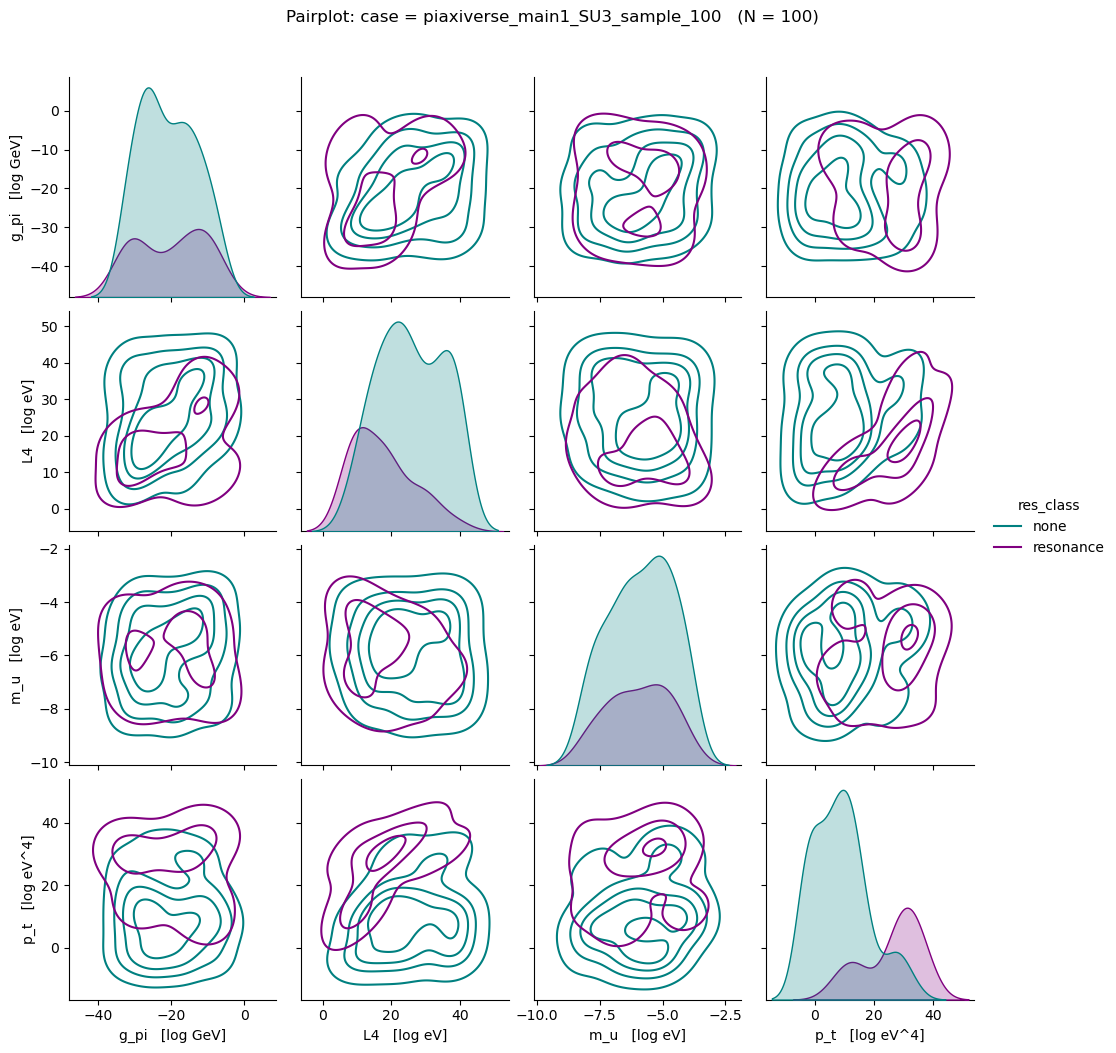

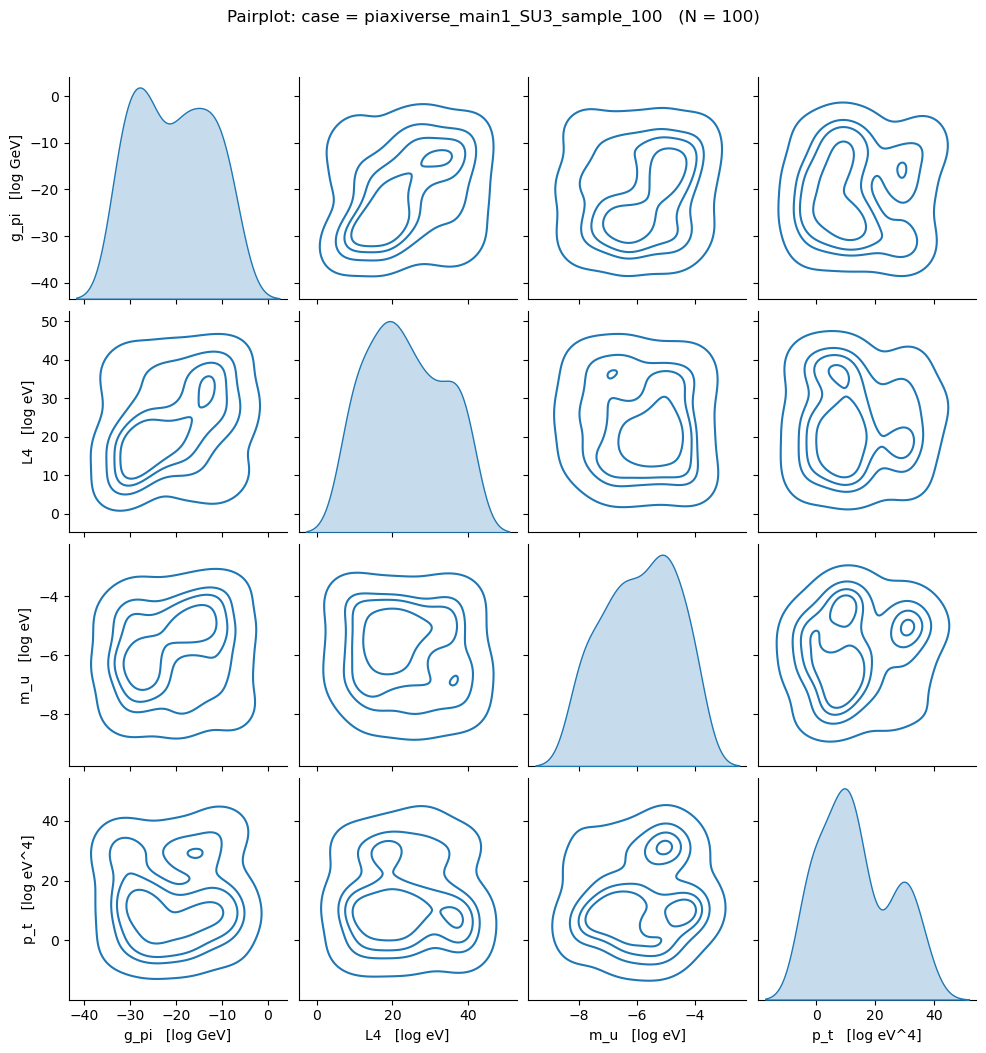

In [12]:
## WIP: Addititional/alternative Pairplot Visualization and importance estimation
show_histograms = False
show_pairplot   = True
show_heatmap    = False
pp_mode         = 'kde'      # 'kde', 'scatter', or 'mixed' pairplot display kinds

log_params  = ['p_0', 'p_t', 'F', 'L3', 'L4', 'm_q', 'eps', 'res_ratio_f', 'res_ratio_m', 'm_0', 'k_0', 'm_u', 'g_pi', 'qm_0', 'qm_1', 'qm_2', 'res_con', 'inf_con']
#log_params  += ['t_u']
dict_params = []
keep_params = ['res_class', 'config_name', 'units', 'res_band_class']

#plot_params = ['F', 'L4', 'm_u', 'p_t', 'eps']
plot_params = ['g_pi', 'L4', 'm_u', 'p_t', 'eps']
fixed_params = {}

# Filter and rescale data for plotting
filter_nonunique  = True
filter_sampled    = True
rescale_logparams = True
infs_to_nans = True
#with pd.option_context("mode.copy_on_write", True):
plot_data = corr_df.copy(deep=True)

def drop_col(col_in, plot_data_in=plot_data, plot_params_in=plot_params):
    plot_data_in.drop(col_in, inplace=True, axis=1)
    if col_in in plot_params_in:
        plot_params_in.remove(col_in)

if infs_to_nans:
    plot_data.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in plot_data.columns:
    if rescale_logparams and col in log_params:
        #print(col)
        plot_data[col] = np.log10(plot_data[col])
    if filter_sampled:
        if col in sampled_params and col not in keep_params:
            drop_col(col)
    if filter_nonunique:
        if len(plot_data[col].unique()) <= 1 and col not in keep_params:
            if col in input_parameters or col in sim_settings_parameters:
                fixed_params[col] = plot_data[col].unique()[0]
                drop_col(col)

# Print out which classes of runs are included in final dataset
if conf_name == 'all':
    print('Including data from the following configurations:')
    dataset_cases = plot_data['config_name'].unique()
    for data_case in dataset_cases:
        print('    |  %s' % data_case)

# TODO/WIP: Histograms
# TODO: Stacked plots with color code for resonance status?
if show_histograms:
    for column in plot_data.columns:
        #print(plot_data[column])
        x = plot_data[column]
        if column in log_params:
            title = 'log %s' % column
        else:
            title = '%s' % column
        plt.hist(x,bins='auto')
        plt.xlabel(title)
        plt.ylabel('N')
        plt.show()

# TODO: Scatter plots?

# TODO/WIP: Pairplots
#           WARNING: Takes a long time / lots of space if large numbers are not properly rescaled
if show_pairplot:
    # temp fix for seaborn version
    import warnings
    warnings.filterwarnings('ignore')
    
    # Format color scheme
    hue_order = ['res_class']
    palette = {'resonance': 'purple', 'burst': 'orange', 'none': 'teal', 'damp': 'grey'}
    
    # Format axes to show units
    fmt_col = lambda c_in: '%s   %s' % (c_in,units_fmt(c_in, prefix='log ' if c_in in log_params else ''))
    plot_data_units = plot_data.rename(columns={col: fmt_col(col) for col in plot_params})
    plot_params_units = [fmt_col(col) for col in plot_params]
    
    # kind = 'kde', 'scatter', 'hist', or 'reg'
    pp_kws  = {'levels':5} if pp_mode == 'kde' else {'alpha':0.35}
    pp_kind = pp_mode if pp_mode != 'mixed' else 'scatter'
    pp = sns.pairplot(plot_data_units, x_vars=plot_params_units, y_vars=plot_params_units, dropna=True, kind=pp_kind, diag_kind='kde', hue='res_class', palette=palette, plot_kws=pp_kws)
    if pp_mode == 'mixed':
        pp.map_offdiag(sns.kdeplot, levels=4, hue_order=['res_class'], palette=palette)
    pp.figure.suptitle('Pairplot: case = %s   (N = %d)' % (conf_name, len(plot_data.index)), y=1.05)

    # Plot unlabelled distribution as well
    if True:
        #pp_kws  = {'levels':5} if pp_mode == 'kde' else {'alpha':0.35}
        #pp_kind = pp_mode if pp_mode != 'mixed' else 'scatter'
        pp_bare = sns.pairplot(plot_data_units, x_vars=plot_params_units, y_vars=plot_params_units, dropna=False, kind=pp_kind, diag_kind='kde', plot_kws=pp_kws)
        if pp_mode == 'mixed':
            pp_bare.map_offdiag(sns.kdeplot, levels=4)
        pp_bare.figure.suptitle('Pairplot: case = %s   (N = %d)' % (conf_name, len(plot_data.index)), y=1.05)

    print('\nSimulation settings:')
    for key, val in fixed_params.items():
        if key in sim_settings_parameters:
            print('%20s :  %10s  [%s]' % (key, str(val), units_fmt(key)))
    
    print('Fixed params:')
    for key, val in fixed_params.items():
        if key in input_parameters:
            print('%20s :  %10s  %s' % (key, str('%.1f' % val) if key in log_params else df_fmt(val, fmt=print_fmt[key]), units_fmt(key, prefix='log ' if key in log_params else '')))

    #print('Units: ')
    #print(param_units)


# TODO: Heatmap for correlation matrix
if show_heatmap:
    sns.heatmap(correlation_matrix, annot=True)

if np.any([show_histograms, show_pairplot, show_heatmap]):
    print('')
    plt.show()

In [8]:
# Find and display subsets of imported data

# Show all 'burst' classification runs
if False:
    burst_df = full_df.copy(deep=True)
    burst_df = burst_df[burst_df['res_class'] == 'burst']
    #print(burst_df.describe())
    with pd.option_context('display.max_colwidth', None):
      print(burst_df['file_name']+'.json')

# Resonant but finite runs
if False:
    finite_df = full_df.copy(deep=True)
    finite_df = finite_df[finite_df['res_class'] == 'resonance']
    finite_df = finite_df[finite_df['t_res'] >= finite_df['t_span_1']]
    #print(finite_df.describe())
    with pd.option_context('display.max_colwidth', None):
      print(finite_df['file_name']+'.json')

## ML Analysis

              L4       g_pi        m_u        p_t    var_d_n
count  70.000000  70.000000  70.000000  70.000000  70.000000
mean   24.642857 -19.726042  -5.938311  13.637379   1.481265
std     9.125590   8.033071   1.283980  12.450523   1.222464
min     9.000000 -32.136721  -8.028960  -2.719764   0.024968
25%    19.000000 -25.886843  -6.878103   3.530236   0.467920
50%    24.000000 -19.636751  -5.736478  12.280236   1.139317
75%    32.750000 -13.386774  -5.104322  26.030236   2.354369
max    39.000000  -7.136721  -3.960113  37.280236   4.786496
---------------------------------------
       res_class  res_ratio_f  res_ratio_m  res_freq_label  res_band_class  \
count  70.000000    70.000000    70.000000       70.000000            70.0   
mean    0.257143          inf          inf        0.942857             0.0   
std     0.440215          NaN          NaN        0.507501             0.0   
min     0.000000     0.000000     0.000000        0.000000             0.0   
25%     0.000000     

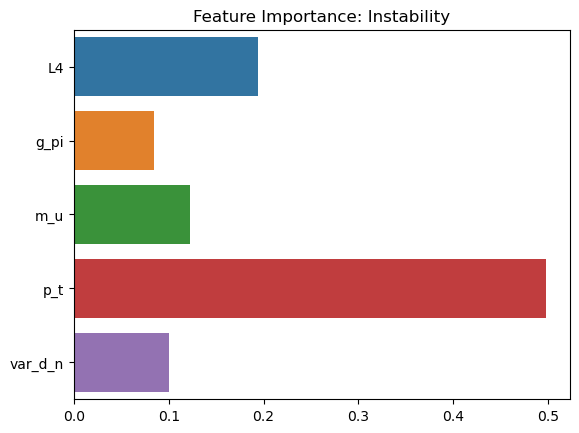

--------------------------
Accuracy: 0.900


In [13]:
## Preprocess data for ML analysis pipeline and assign numerical labels to string-valued parameters
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

ppnan = lambda S_in, nanval=-1: S_in.map(lambda x: np.nan if x is None or x == 'None' else x, na_action='ignore').fillna(value=nanval)
def preprocess_df(X_df_in):
    signal_cols = ['res_freq_class_AXP', 'res_freq_class_Afterglow', 'res_freq_class_CMB', 'res_freq_class_UIE', 'res_freq_class_FRB', 'res_freq_class_GRB']
    #print(X_df_in.isna().any())
    for nan_col in ['res_freq', 'res_band_0', 'res_band_1', 'inf_con'] + signal_cols:
        if nan_col in X_df_in:
            X_df_in[nan_col] = ppnan(X_df_in[nan_col])
    for nan_col in phase_parameters:
        if nan_col in X_df_in:
            X_df_in[nan_col] = ppnan(X_df_in[nan_col], 0)
    
    le = preprocessing.LabelEncoder()
    label_cols = ['config_name', 'int_method', 'res_class', 'res_band_class', 'res_freq_label', 'res_band_0', 'res_band_1'] + signal_cols
    filter_nonunique = True
    for col in X_df_in:
        if col in label_cols:
            X_df_in[col] = le.fit_transform(X_df_in[col])
        if col in log_params:
            X_df_in[col] = X_df_in[col].replace({-1: 1}) # WIP fix for L3 being set to -1 when it is irrelevant
            X_df_in[col] = np.log10(X_df_in[col])
        if filter_nonunique:
            if len(X_df_in[col].unique()) <= 1 and col not in keep_params:
                #if col in input_parameters or col in sim_settings_parameters:
                    drop_col(col, plot_data_in=X_df_in, plot_params_in=[])
    return X_df_in

#with pd.option_context("mode.copy_on_write", True):
X_df = corr_df.copy(deep=True)
X_df = preprocess_df(X_df)

#print(X_df.isna().any())
#overwrite_nans = True
#if overwrite_nans:
#    X_df = X_df.map(lambda x: -1 if pd.isnull(x) or x == np.nan else x)
#print(X_df.describe())

# Pair plot for N_r, N_n, N_c, F
if False:
    pp = sns.pairplot(X_df,  x_vars=['F', 'eps','L3', 'L4', 'm_q'], y_vars=['N_r', 'N_n', 'N_c', 'N_tot'], hue='res_class')
    plt.show()

# Split data into train and test
train, test = train_test_split(X_df, test_size=0.3)

# Separate inputs and outputs
#output_params = ['res_class']
output_params = ['res_class', 'res_ratio_f', 'res_ratio_m', 'res_freq', 'res_freq_label', 'res_band_class', 'time_elapsed', 't_res']
observable_dependents = (['g_pi'] if 'g_pi' not in plot_params else ['F']  if 'F' not in plot_params else []) + \
                        (['g_2']  if 'g_2'  not in plot_params else ['l2'] if 'l2' not in plot_params else []) + \
                        (['g_3']  if 'g_3'  not in plot_params else ['L3'] if 'L3' not in plot_params else []) + \
                        (['g_4']  if 'g_4'  not in plot_params else ['L4'] if 'L4' not in plot_params else []) + \
                        (['m_q']  if 'm_q'  not in plot_params else ['m_u'] if 'm_u' not in plot_params else [])
dependent_params = ['m_0', 't_u', 'qm_0', 'qm_1', 'qm_2'] + observable_dependents
theory_params = ['disable_B', 'disable_P', 'disable_C', 'disable_D', 'qc_0', 'qc_1', 'qc_2', 'qc_3', 'qc_4', 'qc_5']
config_params = ['config_name', 't_num', 'k_num', 'k_span_0', 'k_span_1']
train_params = [out_param for out_param in output_params if out_param in train.columns]
keep_phase_params = ['var_d_n']
drop_phase_params = [phase_param for phase_param in phase_parameters if phase_param not in keep_phase_params]
drop_params = [drop_param for drop_param in (train_params + dependent_params + config_params + theory_params + drop_phase_params) if drop_param in train.columns]

X_train = train.drop(columns=drop_params)
y_train = train[train_params]
X_test = test.drop(columns=drop_params)
y_test = test[train_params]

print(X_train.describe())
print('---------------------------------------')
print(y_train.describe())

# Model training and prediction
clf = RandomForestClassifier()
clf.fit(X_train, y_train['res_class'])  # For 'res_class', repeat for others
# Feature Importance
res_importance = clf.feature_importances_

## Visualization
# Plot feature importance
sns.barplot(x=res_importance, y=X_train.columns)
plt.title('Feature Importance: Instability')
plt.show()

# Evaluate accuracy
y_pred = clf.predict(X_test)
print('--------------------------')
accuracy = accuracy_score(y_test['res_class'], y_pred)
print(f'Accuracy: {accuracy:.3f}')

               F         L4        m_q   num_cores        p_t
count  70.000000  70.000000  70.000000   70.000000  70.000000
mean   27.559994  24.214286 -39.648729  148.228571  14.280236
std     8.023625  10.087865   8.369861   57.888992  12.435340
min    14.301030   9.000000 -54.459170  100.000000  -2.719764
25%    20.551084  14.000000 -46.780611  107.000000   7.280236
50%    26.801061  24.000000 -40.244940  128.000000  12.280236
75%    33.051153  34.000000 -31.441291  128.000000  27.280236
max    39.301030  39.000000 -22.602060  256.000000  37.280236
---------------------------------------
          time_elapsed
count               70
unique              70
top     0:04:54.657546
freq                 1


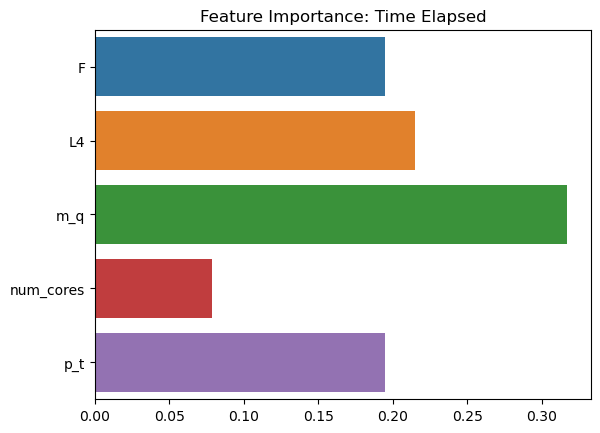

--------------------------
Accuracy: 0.000


In [14]:
# Split data into train and test
#print(time_df.describe())
T_df = preprocess_df(time_df.copy(deep=True))
train, test = train_test_split(T_df, test_size=0.3)

# Separate inputs and outputs
#output_params = ['res_class']
output_params = ['res_class', 'res_ratio_f', 'res_ratio_m', 'res_freq', 'res_freq_label', 'res_band_class', 'time_elapsed', 't_res']
observable_dependents = (['g_pi'] if 'g_pi' not in train.columns else ['F'] if 'F' not in train.columns else []) + (['m_q'] if 'm_q' not in train.columns else ['m_u'] if 'm_u' not in train.columns else [])
dependent_params = ['m_0', 'm_u', 't_u', 'qm_0', 'qm_1', 'qm_2'] + observable_dependents
theory_params = ['disable_B', 'disable_P', 'disable_C', 'disable_D', 'qc_0', 'qc_1', 'qc_2', 'qc_3', 'qc_4', 'qc_5']
config_params = ['config_name', 'k_span_0', 'k_span_1']
complexity_params = ['t_num', 'k_num', 'int_method', 'is_parallel', 'N_tot']
train_params = [out_param for out_param in output_params if out_param in train.columns]
drop_params = [drop_param for drop_param in (train_params + dependent_params + config_params + theory_params + phase_parameters) if drop_param in train.columns]

T_train = train.drop(columns=drop_params)
y_train = train[train_params]
T_test  = test.drop(columns=drop_params)
y_test  = test[train_params]

print(T_train.describe())
print('---------------------------------------')
print(y_train.describe())

# Model training and prediction
clf = RandomForestClassifier()
clf.fit(T_train, y_train['time_elapsed'])  # For 'res_class', repeat for others
# Feature Importance
time_importance = clf.feature_importances_

## Visualization
# Plot feature importance
sns.barplot(x=time_importance, y=T_train.columns)
plt.title('Feature Importance: Time Elapsed')
plt.show()

# Evaluate accuracy
y_pred = clf.predict(T_test)
print('--------------------------')
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

In [17]:
# TODO: Neural Network parameter analysis
# - 3 (?) fully-connected input layers (to capture nonlinearity?)
#    - N = number of inputs? of all parameters? of arbitrarity selection of choice?
# - Variational autoencoder
#    - Depth = ???
#    - # of hidden layers / dimensionality of gaussian = ??? 
# (number of dependent variables? number of species? number of interaction vertices? arbitrary choice? compare quality of prediction and convergence speed / overfitting error for different N-1 to 0)

In [15]:
import os, sys
from pyaxi_utils import g_x_from_m_x, g_x_from_F_pi

# TODO/WIP: Plot heatmap or KDE ranges over AxionLimits for different configuration subsets
def plot_ALP_kde(data_in, verbosity=0, tex_fmt=True, fit_coupling=False):

    tools_dir = os.path.abspath(os.path.join('./tools'))
    if tools_dir not in sys.path:
        sys.path.append(tools_dir)

    # Shade of purple chosen for visibility against existing plot colors
    res_color  = '#b042f5'

    if 'g_pi' not in data_in.columns:
        if fit_coupling:
            data_in['g_pi'] = data_in.apply(lambda x, GeV=1e9: g_x_from_m_x(F_pi=x['m_u'], epsilon=x['eps'], lambda1=x['l1']), axis=1)
        else:
            data_in['g_pi'] = data_in.apply(lambda x, GeV=1e9: g_x_from_F_pi(F_pi=x['F']/GeV), axis=1)

    zoomed_out = True
    centered = False
    if zoomed_out:
        m_ref_min = 1e-22
        m_ref_max = 1e3
        g_ref_min = 1e-28
        g_ref_max = 1e-5
    else:
        m_ref_min = 1e-12
        m_ref_max = 1e2
        g_ref_min = 1e-21
        g_ref_max = 1e-8
    if centered:
        m_min = np.max([np.min(data_in['m_u'])*1e-2,  m_ref_min])
        m_max = np.min([np.max(data_in['m_u'])*1e2,   m_ref_max])
        g_min = np.max([np.min(data_in['g_pi'])*1e-2, g_ref_min])
        g_max = np.min([np.max(data_in['g_pi'])*1e2,  g_ref_max])
    else:
        m_min = np.min([np.min(data_in['m_u'])*1e-2,  m_ref_min])
        m_max = np.max([np.max(data_in['m_u'])*1e2,   m_ref_max])
        g_min = np.min([np.min(data_in['g_pi'])*1e-2, g_ref_min])
        g_max = np.max([np.max(data_in['g_pi'])*1e2,  g_ref_max])

    # Import plotting functions from AxionLimits and set up AxionPhoton plot
    from PlotFuncsLocal import FigSetup, AxionPhoton, MySaveFig, BlackHoleSpins, FilledLimit, line_background
    fig, ax = FigSetup(Shape='Rectangular', ylab='$|g_{\pi\gamma\gamma}|$ [GeV$^{-1}$]', mathpazo=True,
                       m_min=m_min, m_max=m_max, g_min=g_min, g_max=g_max)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    ## Populate standard AxionPhoton limits plot
    
    # Separate z-layers for axion mass-coupling projections and experimental bounds
    ax0 = plt.gcf().add_subplot()
    ax0.set_xscale('log')
    ax0.set_xlim(xmin, xmax)
    ax0.set_yscale('log')
    ax0.set_ylim(ymin, ymax)
    ax0.axis('off')
    ax0.set_zorder(1)
    
    # Plot QCD axion lines and experimental bounds
    AxionPhoton.QCDAxion(ax0,C_center=abs(5/3-1.92)*(44/3-1.92)/2,C_width=0.7,vmax=1.1)
    
    ## TODO: Verify we are using the appropriate equation to calculate the g_pi-m_pi relation
    # Reference Lines
    AxionPhoton.piAxion(ax0,epsilon=1,lambda1=1,theta=1,label_mass=1e-2,C_logwidth=10,cmap='Greys',fs=18,rot = 6.0,
                    C_center=1,C_width=1.2,vmax=0.9)
    AxionPhoton.piAxion(ax0,epsilon=0.5,lambda1=1,theta=1,label_mass=1e-2,C_logwidth=10,cmap='Greys',fs=18,rot = 6.0,
                    C_center=1,C_width=1.2,vmax=0.9)
    AxionPhoton.piAxion(ax0,epsilon=0.01,lambda1=1,theta=1,label_mass=1e-2,C_logwidth=10,cmap='Greys',fs=18,rot = 6.0,
                    C_center=1,C_width=1.2,vmax=0.9)
    
    # Now the experimental bounds
    ax1 = plt.gcf().add_subplot()
    ax1.set_xscale('log')
    ax1.set_xlim(xmin, xmax)
    ax1.set_yscale('log')
    ax1.set_ylim(ymin, ymax)
    ax1.axis('off')
    ax1.set_zorder(3)
    
    AxionPhoton.Cosmology(ax1, text_on=False)
    #AxionPhoton.ColliderBounds(ax1, text_on=True)
    AxionPhoton.StellarBounds(ax1, text_on=False)
    AxionPhoton.SolarBasin(ax1, text_on=False)
    AxionPhoton.Haloscopes(ax1, projection=True, BASE_arrow_on=False, text_on=False)
    #AxionPhoton.HaloscopesUniform(ax1, projection=True, text_on=False)
    AxionPhoton.Helioscopes(ax1, projection=True, text_on=False)
    AxionPhoton.LSW(ax1, projection=True, text_on=False)
    AxionPhoton.LowMassAstroBounds(ax1, projection=True, text_on=False)
    AxionPhoton.ULAs(ax1, projection=True, text_on=False)

    # Dark matter astro/cosmo bounds:
    AxionPhoton.ALPdecay(ax1, projection=True, text_on=False)
    AxionPhoton.NeutronStars(ax1, text_on=False)
    AxionPhoton.AxionStarExplosions(ax1, text_on=False)

    data_QCD  = data_in[data_in['N_r']   ==  1]     # Plot only single field cases, for example
    data_SU3  = data_in[data_in['N_tot'] ==  3]     
    data_SU6  = data_in[data_in['N_tot'] == 20]     
    data_any  = data_in[data_in['N_r']   >=  1]     
    data_plt  = data_in
    
    ax2 = plt.gcf().add_subplot()
    ax2.set_xscale('log')
    ax2.set_xlim(xmin, xmax)
    ax2.set_yscale('log')
    ax2.set_ylim(ymin, ymax)
    ax2.axis('off')
    ax2.set_zorder(2)

    # Format color scheme
    hue_order = ['res_class']
    palette = {'resonance': 'magenta', 'burst': 'orange', 'none': 'teal', 'damp': 'grey'}
    
    sns.kdeplot(ax=ax2, data=data_plt, x='m_u', y='g_pi', hue=hue_order[0], palette=palette, levels=3, fill=False, alpha=0.7, legend=False)
    
    '''
    ## Plot star marker for this specific parameter configuration
    # Primary data
    ax1 = plt.gcf().add_subplot()
    ax1.set_xscale('log')
    ax1.set_xlim(xmin, xmax)
    ax1.set_yscale('log')
    ax1.set_ylim(ymin, ymax)
    ax1.axis('off')
    ax1.set_zorder(3)
    #g_u = GeV/F
    if fit_coupling:
        g_u = g_x_from_m_x(m_u, epsilon=eps, lambda1=l1)
    else:
        g_u = g_x_from_F_pi(F_pi=F/GeV, eps=eps, l1=l1)
    ax1.scatter(m_u, g_u, s=2000, c='white', marker='*')
    ax1.scatter(m_u, g_u, s=1000, c=res_color, marker='*')

    # Secondary Data
    ax2 = plt.gcf().add_subplot()
    ax2.set_xscale('log')
    ax2.set_xlim(xmin, xmax)
    ax2.set_yscale('log')
    ax2.set_ylim(ymin, ymax)
    ax2.axis('off')
    ax2.set_zorder(2)
    if len(m[0] > 1):
        for m_v in m[0][1:]:
            if fit_coupling:
                g_v = g_x_from_m_x(m_v, epsilon=eps, lambda1=l1)
            else:
                g_v = g_x_from_F_pi(F_pi=F/GeV, eps=eps, l1=l1)
            ax2.scatter(m_v, g_v, s=1000, c='grey', marker='*')
    '''
    #plt.legend()
    plt.show()

    
#with pd.option_context("mode.copy_on_write", True):
ALP_df = corr_df.copy(deep=True)
with pd.option_context('display.max_columns', None):
    #print(ALP_df.describe())
    print(ALP_df.columns)
plot_ALP_kde(ALP_df, verbosity=9, tex_fmt=False, fit_coupling=False)

Index(['A_0', 'A_pm', 'Adot_0', 'F', 'L3', 'L4', 'N_c', 'N_n', 'N_r', 'N_tot',
       'config_name', 'disable_B', 'disable_C', 'disable_D', 'disable_P',
       'eps', 'g_3', 'g_4', 'g_pi', 'g_qed', 'inf_con', 'int_method', 'k_0',
       'k_num', 'k_span_0', 'k_span_1', 'm_0', 'm_q', 'm_u', 'max_Th_c',
       'max_Th_n', 'max_Th_r', 'max_Th_tot', 'max_d_c', 'max_d_n', 'max_d_r',
       'max_d_tot', 'mean_Th_c', 'mean_Th_n', 'mean_Th_r', 'mean_Th_tot',
       'mean_d_c', 'mean_d_n', 'mean_d_r', 'mean_d_tot', 'min_Th_c',
       'min_Th_n', 'min_Th_r', 'min_Th_tot', 'min_d_c', 'min_d_n', 'min_d_r',
       'min_d_tot', 'mu_Th', 'mu_d', 'p_0', 'p_t', 'qc_0', 'qc_1', 'qc_2',
       'qc_3', 'qc_4', 'qc_5', 'qm_0', 'qm_1', 'qm_2', 'res_band_0',
       'res_band_1', 'res_band_class', 'res_class', 'res_con', 'res_freq',
       'res_freq_class_AXP', 'res_freq_class_Afterglow', 'res_freq_class_CMB',
       'res_freq_class_FRB', 'res_freq_class_GRB', 'res_freq_class_UIE',
       'res_freq_label', 'r

RuntimeError: latex was not able to process the following string:
b'$\\\\mathdefault{10^{0}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../70d13c9f7ce28605213e7095886a237b.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathpazo.sty)

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 70d13c9f7ce28605213e7095886a237b.log.




<Figure size 1650x1100 with 4 Axes>

In [ ]:
## WIP: Reduce dimensionality of input data parameter space with PCA

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

# Step 1: Load and pre-process dataset
X_df_pca_in = preprocess_df(corr_df.copy(deep=True))
X_df_pca_in['res_ratio_m'] = X_df_pca_in['res_ratio_m'].apply(lambda x: -1. if np.isnan(x) or np.isinf(x) else x)
X_df_pca_in['res_ratio_f'] = X_df_pca_in['res_ratio_f'].apply(lambda x: -1. if np.isnan(x) or np.isinf(x) else x)
#train, test = train_test_split(X_df_pca_in, test_size=0.3)

output_params = ['res_class', 'res_ratio_f', 'res_ratio_m', 'res_freq', 'res_freq_label', 'res_band_class', 'time_elapsed', 't_res']
observable_dependents = (['g_pi'] if 'g_pi' not in plot_params else ['F']  if 'F' not in plot_params else []) + \
                        (['g_2']  if 'g_2'  not in plot_params else ['l2'] if 'l2' not in plot_params else []) + \
                        (['g_3']  if 'g_3'  not in plot_params else ['L3'] if 'L3' not in plot_params else []) + \
                        (['g_4']  if 'g_4'  not in plot_params else ['L4'] if 'L4' not in plot_params else []) + \
                        (['m_q']  if 'm_q'  not in plot_params else ['m_u'] if 'm_u' not in plot_params else [])
dependent_params = ['m_0', 't_u', 'qm_0', 'qm_1', 'qm_2'] + observable_dependents
theory_params = ['disable_B', 'disable_P', 'disable_C', 'disable_D', 'qc_0', 'qc_1', 'qc_2', 'qc_3', 'qc_4', 'qc_5']
config_params = ['config_name', 't_num', 'k_num', 'k_span_0', 'k_span_1']
train_params = [out_param for out_param in output_params if out_param in X_df_pca_in.columns]
keep_phase_params = ['var_d_n']
#drop_phase_params = [phase_param for phase_param in phase_parameters if phase_param not in keep_phase_params]
drop_phase_params = []
drop_params = [drop_param for drop_param in (train_params + dependent_params + config_params + drop_phase_params) if drop_param in X_df_pca_in.columns]

#X_train = train.drop(columns=drop_params)
#y_train = train[train_params]
#X_test  = test.drop(columns=drop_params)
#y_test  = test[train_params]

X_df_pca_in.drop(columns=drop_params)
if True:
    print('Original dataframe: \n', X_df_pca_in.describe())
    #print('---------------------------------------')

#y_df = X_df_pca_in[train_params]
#print(y_df.describe())
#print('---------------------------------------')

# Step 2: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df_pca_in)

#print('---------------------------------------')
#print(pd.DataFrame(X_scaled, columns=X_df_pca_in.columns).describe())


# Step 3: Apply PCA and determine the number of components
# Compute PCA
pca = PCA(n_components=None)  # n_components can be set to a specific number or None for all components

# Fit PCA on the standardized data
pca.fit(X_scaled)

# Calculate cumulative explained variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Decide the number of components based on cumulative explained variance (e.g., 95%)
n_components = np.argmax(explained_variance_ratio >= 0.95) + 1

print('---------------------------------------')
print(f"Number of components needed to explain 95% variance: {n_components}")

# Step 4: Transform the data using PCA
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Step 5: Use the reduced data for further analysis or modeling
# For example, you can now use X_pca as input to a machine learning model

print(f"Original shape: {X_df_pca_in.shape}")
print(f"Reduced shape: {X_pca.shape}")

X_pca_df = pd.DataFrame(X_pca, columns=[f'PCA_{str(i).zfill(2)}' for i in range(n_components)])

print('---------------------------------------')
print(X_pca_df.describe())

---------------------------------------
Number of components needed to explain 95% variance: 11
Original shape: (100, 33)
Reduced shape: (100, 11)
---------------------------------------
             PCA_00        PCA_01        PCA_02        PCA_03        PCA_04  \
count  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02   
mean  -1.509903e-16 -8.881784e-18 -3.441691e-17 -7.327472e-17  6.661338e-18   
std    2.804598e+00  2.530175e+00  2.143555e+00  1.705137e+00  1.389902e+00   
min   -5.286658e+00 -5.176590e+00 -2.657706e+00 -2.806101e+00 -2.859141e+00   
25%   -2.363686e+00 -1.881978e+00 -1.324797e+00 -1.231174e+00 -7.169138e-01   
50%   -3.926614e-01 -5.525739e-01 -8.881243e-01 -3.541335e-01 -1.272571e-01   
75%    2.440171e+00  1.940548e+00  1.082077e+00  1.041126e+00  6.349545e-01   
max    5.832069e+00  5.483422e+00  5.595956e+00  6.079110e+00  4.715440e+00   

             PCA_05        PCA_06        PCA_07        PCA_08        PCA_09  \
count  1.000000e+02  1

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino


          PCA_00     PCA_01     PCA_02     PCA_03     PCA_04     PCA_05  \
count  80.000000  80.000000  80.000000  80.000000  80.000000  80.000000   
mean   -0.055055   0.059479  -0.036856  -0.063030   0.129364   0.108438   
std     2.732033   2.657172   2.090079   1.701927   1.461733   1.294000   
min    -5.286658  -5.176590  -2.657706  -2.806101  -2.859141  -1.852074   
25%    -2.311355  -1.995322  -1.324707  -1.245820  -0.586779  -0.851641   
50%    -0.472695  -0.739219  -0.848329  -0.381382  -0.027499  -0.151982   
75%     2.266808   2.107235   1.082077   0.931391   0.740496   0.847754   
max     5.832069   5.483422   5.595956   6.079110   4.715440   3.988459   

          PCA_06     PCA_07     PCA_08     PCA_09     PCA_10  
count  80.000000  80.000000  80.000000  80.000000  80.000000  
mean    0.005348   0.008965   0.010358  -0.071611  -0.018124  
std     1.106370   1.077660   0.945073   0.830602   0.822760  
min    -2.887126  -2.432037  -2.129679  -1.937564  -1.875977  
25%    -0

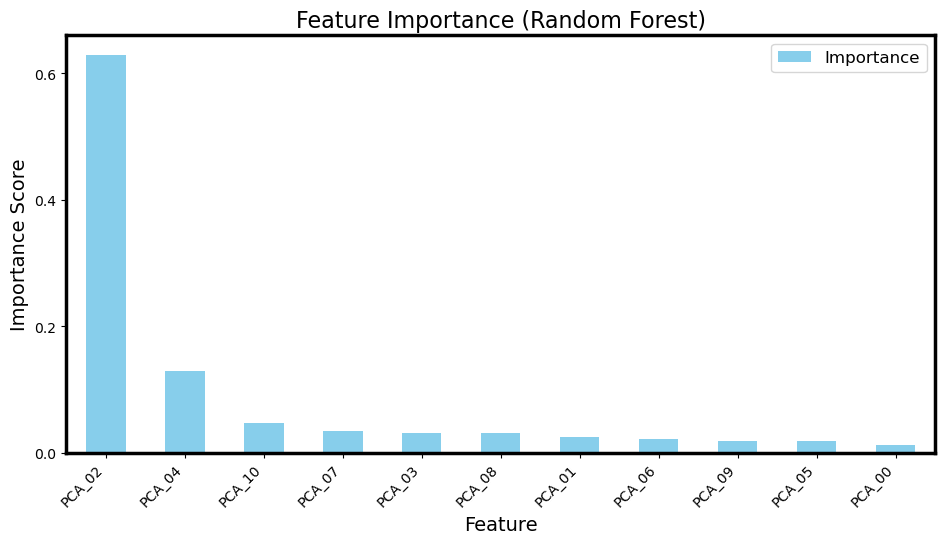

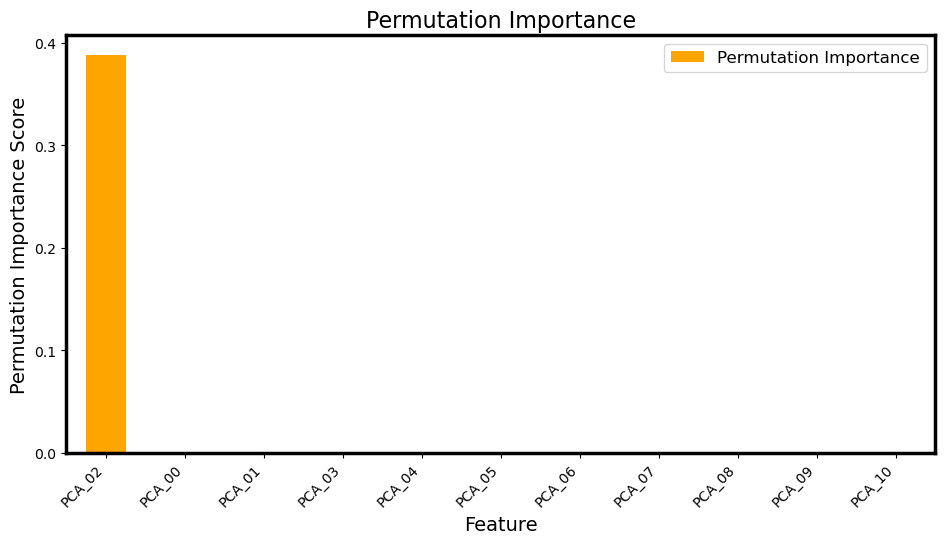

In [17]:
## TODO/WIP: RandomForestClassifier trained on input data with new reduced dimensionality and feature importance plotting
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

use_PCA_params = True
plot_permutation_importance = True
use_tex_format = False

if not use_tex_format:
    plt.rcParams.update({
        'text.usetex': False,
        'font.family': 'serif',
    })
    plt.rc('text', usetex=False)

# Generate synthetic dataset (example)
#n_samples = 10000
#n_features = 500  # High-dimensional space

#X = np.random.randn(n_samples, n_features)  # Input features
#y = np.random.binomial(1, 0.5, n_samples)   # Binary labels

if use_PCA_params:
    X_df_in = X_pca_df.copy(deep=True)
else:
    X_df_in = X_df.copy(deep=True)
    X_df_in = X_df_in.drop(columns=drop_params)

# Split data into training and testing sets
y_df = X_df['res_class']
X_train, X_test, y_train, y_test = train_test_split(X_df_in, y_df, test_size=0.2, random_state=42)

# Initialize Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

print(X_train.describe())
print('-----------------------------')
print(y_train.describe())

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate accuracy
print('--------------------------')
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

# Extract Feature Importances
feature_names = X_train.columns
feature_importances = clf.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort features by importance in descending order
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot Feature Importances using matplotlib
#plt.figure(figsize=(10, 6))
fig1 = importance_df.plot(x='Feature', y='Importance', kind='bar', color='skyblue', figsize=(10,6), fontsize=10)

plt.title('Feature Importance (Random Forest)', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance Score', fontsize=14)
plt.legend(fontsize=12)
feature_labels = [r'$\texttt{%s}$' % feature_name for feature_name in importance_df['Feature']] if use_tex_format else importance_df['Feature']
plt.xticks(rotation=45, ha='right', labels=feature_labels, ticks=range(len(feature_labels)))
plt.tight_layout()
plt.show()

if plot_permutation_importance:
    # Optional - Calculate and Plot Permutation Importances
    result = permutation_importance(clf, X_df_in, y_df, n_repeats=10, random_state=42)
    perm_importance = pd.DataFrame({
        'Feature': feature_names,
        'Permutation Importance': result.importances_mean
    })

    # Sort by permutation importance in descending order
    perm_importance = perm_importance.sort_values('Permutation Importance', ascending=False)

    #plt.figure(figsize=(10, 6))
    fig2 = perm_importance.plot(x='Feature', y='Permutation Importance', kind='bar', color='orange', figsize=(10,6), fontsize=10)

    plt.title('Permutation Importance', fontsize=16)
    plt.xlabel('Feature', fontsize=14)
    plt.ylabel('Permutation Importance Score', fontsize=14)
    plt.legend(fontsize=12)
    feature_labels = [r'$\texttt{%s}$' % feature_name for feature_name in perm_importance['Feature']] if use_tex_format else perm_importance['Feature']
    plt.xticks(rotation=45, ha='right', labels=feature_labels, ticks=range(len(feature_labels)))
    plt.tight_layout()
    plt.show()

In [35]:
## Analyze PCA results
pca_in = pca

# TODO: Plot over a range of components
comp_in = pca_in.components_[2]

# Identify how much each component is contributing to the given PCA component
feature_contributions = pd.DataFrame({
    'Feature': X_df_pca_in.columns,
    'Loading': comp_in,
})
sorted_features = feature_contributions.sort_values(
    by='Loading', key=abs, ascending=False
)

print(sorted_features.describe())

# Plot their contributions
plt.figure(figsize=(10, 6))
sorted_features.plot(kind='bar', x='Feature', y='Loading')
plt.title('Feature Contributions to Dominant Principal Component')
plt.xlabel('Feature')
plt.ylabel('Loading')
plt.xticks(rotation=45, ha='right')
plt.show()

AttributeError: 'PCA' object has no attribute 'get_feature_names_out'

In [14]:
## TODO/WIP: Variational Autoencoders 
##        - in order to learn and display instability plots
##        - in order to learn and display the above mass-coupling projection
##        - What should the dimensionality of the latent space be? N_f? number of free model parameters?
##            --> PCA?


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
from tensorboardX import SummaryWriter

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256)
        )
        
        # Mean and log variance layers
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_log_var = nn.Linear(256, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from a normal distribution
        with mean and log variance.
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        # Encode
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        
        # Reparameterize
        z = self.reparameterize(mu, log_var)
        
        # Decode
        reconstructed_x = self.decoder(z)
        
        return reconstructed_x, mu, log_var

# Define loss function
def vae_loss(reconstructed_x, x, mu, log_var):
    """
    VAE loss function: Reconstruction + KL divergence losses.
    """
    # BCE reconstruction loss
    bce_loss = nn.functional.binary_cross_entropy_with_logits(reconstructed_x, x.view(-1, 784))
    
    # KL divergence
    kl_div = -0.5 * torch.mean(1 + log_var - mu**2 - torch.exp(log_var))
    
    return bce_loss + kl_div

class PyaxiDataset(Dataset):
    def __init__(self, data_df):
        self.data = data_df.values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])

# Set up training parameters
batch_size = 128
learning_rate = 0.001
num_epochs = 100
latent_dim = 2

# Data loading
#train_dataset = MNIST(root='data', train=True, transform=ToTensor(), download=True)
train_dataset_df = X_df.copy(deep=True)
print(train_dataset_df.describe())
print('-----------------------------------------------')
train_dataset = PyaxiDataset(train_dataset_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(train_loader.dataset)
print('----------------------------')

# Initialize model and optimizer
model = VAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up TensorBoard writer
writer = SummaryWriter('logs/vae_logs')

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(epoch)
    for i, x in enumerate(train_loader):
        print(i)
        print(x)
    for batch_idx, (x, _) in enumerate(train_loader):
        print(batch_idx)
        # Convert data to float and normalize
        x = x.float()
        
        # Forward pass
        reconstructed_x, mu, log_var = model(x)
        
        # Compute loss
        loss = vae_loss(reconstructed_x, x, mu, log_var)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    
    # Log to TensorBoard
    writer.add_scalar('training_loss', avg_loss, epoch)
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Close TensorBoard writer
writer.close()

                F          L4  config_name           g_4        g_pi  \
count  100.000000  100.000000        100.0  1.000000e+02  100.000000   
mean    27.769817   23.500000          0.0  2.043796e-03  -20.605508   
std      8.089425    9.936668          0.0  5.091023e-03    8.089425   
min     14.301030    9.000000          0.0  1.459854e-62  -32.136721   
25%     20.551084   14.000000          0.0  1.459854e-52  -29.011782   
50%     26.801061   24.000000          0.0  1.459854e-32  -19.636751   
75%     36.176091   34.000000          0.0  1.459854e-12  -13.386774   
max     39.301030   39.000000          0.0  1.459854e-02   -7.136721   

              m_0         m_q         m_u     max_d_n     max_d_r   max_d_tot  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     5.891875  -39.842224   -5.891875    3.245378    1.970006    1.970006   
std      1.237442    8.716609    1.237442    1.519761    1.656006    1.656006   
min      3.960113  -55.6020

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
## TODO: Bilby analysis for parameter estimation?
##         - To ensure we recover injected signals from VAE output?
##         - Can we use Bilby to estimate parameters of model (N_f, masses, couplings) using power spectrum data?